In [35]:
import pandas as pd
import numpy as np
import re 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from wordcloud import WordCloud
import plotly.io as pio
import plotly.graph_objects as go

pio.kaleido.scope.default_format = "png"
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Clean Data

In [36]:
survey = pd.read_csv('survey.csv')
survey = survey[2:]
survey.columns = survey.columns.str.strip()
survey.drop(
    columns=[
        'StartDate',
        'EndDate',
        'Status',
        'Progress',
        'DistributionChannel',
        'UserLanguage',
        'Finished'
    ]
).head(3)

survey['Duration (in seconds)'] = pd.to_numeric(survey['Duration (in seconds)'], errors='coerce')

print(len(survey))
survey = survey[survey['Q_DuplicateRespondent'] != 'true']
print(len(survey))

238
227


In [37]:
rename_dict = {
    'Q1': 'year_of_study',
    'Q2': 'lse_accommodation',
    'Q3': 'department',
    'Q4': 'society_or_sports_team',
    'Q5': 'is_virgin',
    'Q6': 'body_count',
    'Q8': 'sexuality',
    'Q8_5_TEXT': 'sexuality_other_text',
    'Q9': 'gender',
    'Q9_4_TEXT': 'gender_other_text',
    'Q10': 'sex_positions_tried',
    'Q10_8_TEXT': 'sex_positions_tried_other_text',
    'Q11': 'favourite_sex_position',
    'Q11_8_TEXT': 'favourite_sex_position_other_text',
    'Q12': 'had_sex_on_campus',
    'Q13': 'sex_on_campus_location',
    'Q14': 'kinks_participated',
    'Q14_9_TEXT': 'kinks_other_text',
    'Q15': 'sex_frequency',
    'Q16': 'had_same_gender_sex',
    'Q17': 'relationship_status',
    'Q18': 'number_of_regular_sexual_partners',
    'Q19': 'masturbation_frequency',
    'Q20': 'watches_porn',
    'Q21': 'porn_genres_watched',
    'Q21_13_TEXT': 'porn_genres_other_text',
    'Q22': 'has_cheated',
    'Q23': 'has_been_cheated_on',
    'Q24': 'had_std',
    'Q25': 'std_type',
    'Q26': 'had_threesome',
    'Q27': 'max_partners_at_once',
    'Q28': 'hooked_up_with_sway',
    'Q29': 'dating_apps_used',
    'Q29_6_TEXT': 'dating_apps_other_text'}

In [38]:
survey = survey.rename(columns=rename_dict)
survey.columns

Index(['StartDate', 'EndDate', 'Status', 'Progress', 'Duration (in seconds)',
       'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel',
       'UserLanguage', 'Q_DuplicateRespondent', 'Q_BallotBoxStuffing',
       'year_of_study', 'lse_accommodation', 'department',
       'society_or_sports_team', 'is_virgin', 'body_count', 'sexuality',
       'sexuality_other_text', 'gender', 'gender_other_text',
       'sex_positions_tried', 'sex_positions_tried_other_text',
       'favourite_sex_position', 'favourite_sex_position_other_text',
       'had_sex_on_campus', 'sex_on_campus_location', 'kinks_participated',
       'kinks_other_text', 'sex_frequency', 'had_same_gender_sex',
       'relationship_status', 'number_of_regular_sexual_partners',
       'masturbation_frequency', 'watches_porn', 'porn_genres_watched',
       'porn_genres_other_text', 'has_cheated', 'has_been_cheated_on',
       'had_std', 'std_type', 'had_threesome', 'max_partners_at_once',
       'hooked_up_with_sway

In [39]:
survey['society_or_sports_team'].unique()

array([nan, 'Beaver', 'The Beaver', 'HKPASS', 'Commodities, Trading',
       'Law, Badminton', 'Singapore, Dance', 'Dance ', 'Pilates',
       'Frisbee ', 'LSE Commodities', 'Itchy feet, hiking soc',
       'Israeli society', 'Beaver \n', 'Womens Rugby',
       'Effective Altruism', 'women’s rugby, jiu jitsu', 'Dance',
       'Tennis ', 'Economics Society',
       'The Beaver, Malayali Society, Women in Politics, India society ',
       'Tennis', 'Women’s football', 'pilates ', 'Non', 'Netball',
       'KCSOC, yoga society', 'BIG', 'Padel', 'Consulting Sociefy ',
       'pole', 'Grimshaw ', 'Northern', 'Swimming', 'No', 'secret',
       'Geopolitics, Labour, European, chess, debate, London globalist',
       'Surf', 'Pilates Album PnP Music', 'Debate', 'Snow sports ',
       'Lacrosse', 'rugby tennis', 'Squash', 'Boxing, Spanish\n',
       'Baseball', '/', 'GovSoc', '-', 'Choir, beaver, Clare market ',
       'climbing, ski', 'Climbing', 'Gymnastics ', 'Yoga',
       'American football

In [40]:
multi_cols = [
    'sex_positions_tried',
    'kinks_participated',
    'porn_genres_watched',
    'dating_apps_used'
]

for col in multi_cols:
    dummies = (
        survey[col]
        .fillna('')
        .str.get_dummies(sep=',')          
    )

    dummies.columns = [
        f'{col}__' + c.strip().lower().replace(' ', '_')
        for c in dummies.columns
        if c.strip() != ''
    ]

    survey = survey.join(dummies)


In [41]:
print(list(survey.columns))

['StartDate', 'EndDate', 'Status', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel', 'UserLanguage', 'Q_DuplicateRespondent', 'Q_BallotBoxStuffing', 'year_of_study', 'lse_accommodation', 'department', 'society_or_sports_team', 'is_virgin', 'body_count', 'sexuality', 'sexuality_other_text', 'gender', 'gender_other_text', 'sex_positions_tried', 'sex_positions_tried_other_text', 'favourite_sex_position', 'favourite_sex_position_other_text', 'had_sex_on_campus', 'sex_on_campus_location', 'kinks_participated', 'kinks_other_text', 'sex_frequency', 'had_same_gender_sex', 'relationship_status', 'number_of_regular_sexual_partners', 'masturbation_frequency', 'watches_porn', 'porn_genres_watched', 'porn_genres_other_text', 'has_cheated', 'has_been_cheated_on', 'had_std', 'std_type', 'had_threesome', 'max_partners_at_once', 'hooked_up_with_sway', 'dating_apps_used', 'dating_apps_other_text', 'sex_positions_tried__69', 'sex_positions_tried__cowgir

In [42]:
def split_multi_entry(value):
    """Split a messy free-text 'multiple societies' field into tokens."""
    if pd.isna(value):
        return []

    s = str(value).strip()
    s = re.sub(r'\s+', ' ', s)

    none_like = {'no', 'n/a', 'na', 'non', 'none', '-', '/', 'secret', 'naa'}
    if s.lower() in none_like:
        return []

    # normalize separators to commas
    s = re.sub(r'(\n|/|;|\|)', ',', s)
    s = re.sub(r'\s*&\s*', ',', s)
    s = re.sub(r'\s+and\s+', ',', s, flags=re.I)

    parts = [p.strip() for p in s.split(',') if p.strip()]
    return parts


def canonicalize_society(token):
    """
    Normalize a single token to a canonical label.
    Expand synonym_map as you see new values.
    """
    t = str(token).strip().lower()
    t = re.sub(r'\s+', ' ', t)

    # remove punctuation but keep spaces
    t_clean = re.sub(r"[^\w\s']", '', t).strip()

    # junk tokens
    if t_clean in {'', 'lse', 'lsesu'}:
        return None

    # key synonyms (add to this list as needed)
    synonym_map = {
        # Beaver
        'beaver': 'Beaver',
        'the beaver': 'Beaver',
        'lsesu beaver': 'Beaver',


        # sports formatting
        'womens rugby': "Women's Rugby",
        'women’s rugby': "Women's Rugby",
        'rugby': 'Rugby',
        'women’s football': "Women's Football",
        'womens football': "Women's Football",
        'women’s basketball': "Women's Basketball",
        'womens basketball': "Women's Basketball",

        # common sports / societies
        'tennis': 'Tennis',
        'padel': 'Squash and Padel',
        'squash': 'Squash and Padel',
        'netball': 'Netball',
        'rowing': 'Rowing',
        'swimming': 'Swimming',
        'cricket': 'Cricket',
        'baseball': 'Baseball',
        'lacrosse': 'Lacrosse',
        'american football': 'American Football',
        'futsal': 'Futsal',
        'basketball': 'Basketball',
        'boxing': 'Boxing',
        'muay thai': 'Muay Thai',
        'jiu jitsu': 'Jiu Jitsu',
        'climbing': 'Climbing',
        'surf': 'Surf',
        'snow sports': 'Snow Sports',
        'ski': 'Snow Sports',
        'snow': 'Snow Sports',

        # wellness
        'pilates': 'Pilates',
        'yoga': 'Yoga',
        'yoga society': 'Yoga',
        'pole': 'Pole',
        'pole fitness': 'Pole',

        # academics
        'economics society': 'Academic Society',
        'big': 'Pre Professional Society',
        'govsoc': 'GovSoc',
        'government society': 'GovSoc',
        'consulting sociefy': 'Pre Professional Society',
        'consulting society': 'Pre Professional Society',
        'accounting soc': 'Academic Society',
        'women in politics': 'Pre Professional Society',

        # culture/national
        'israeli society': 'Socio-Cultural Society',
        'india society': 'Socio-Cultural Society',
        'singapore': 'Socio-Cultural Society',
        'singapore society': 'Socio-Cultural Society',
        'malayali society': 'Socio-Cultural Society',
        'filsoc': 'Socio-Cultural Society',
        'northern': 'Socio-Cultural Society',

        # arts/media
        'music': 'Music Society',
        'choir': 'Music Society',
        'drama': 'Drama',
        'debate': 'Debate',
        'loose tv': 'Loose TV',

        # other tokens
        'cds': 'Other',
        'kcsoc': 'Other',
        'hkpass': 'Other',
    }

    if t_clean in synonym_map:
        return synonym_map[t_clean]

    # Default: title-case unknowns (still standardized)
    return t_clean.title()


def build_society_list(series):
    out = []
    for v in series:
        raw_tokens = split_multi_entry(v)
        canon = []
        for tok in raw_tokens:
            c = canonicalize_society(tok)
            if c is not None and c not in canon:
                canon.append(c)
        out.append(canon)
    return out

def to_snake_case_label(s):
    s = str(s).strip().lower()
    s = re.sub(r'&', 'and', s)
    s = re.sub(r'[^a-z0-9]+', '_', s)
    s = re.sub(r'_+', '_', s).strip('_')
    return s


def add_society_multihot(df, source_col='society_or_sports_team', prefix='soc__'):
    df = df.copy()
    df['society_list'] = build_society_list(df[source_col])
    all_labels = sorted({lab for labs in df['society_list'] for lab in labs})

    new_cols = [f"{prefix}{to_snake_case_label(lab)}" for lab in all_labels]
    soc_dummies = pd.DataFrame(0, index=df.index, columns=new_cols, dtype='int64')

    label_to_col = {lab: f"{prefix}{to_snake_case_label(lab)}" for lab in all_labels}

    for i, labs in enumerate(df['society_list']):
        for lab in labs:
            soc_dummies.loc[df.index[i], label_to_col[lab]] = 1

    df = pd.concat([df, soc_dummies], axis=1)
    return df, new_cols

survey, soc_cols = add_society_multihot(survey)
print(len(soc_cols), 'society columns created')
survey[soc_cols].sum().sort_values(ascending=False).head(20)


71 society columns created


soc__tennis                      11
soc__beaver                       9
soc__socio_cultural_society       5
soc__pre_professional_society     4
soc__squash_and_padel             4
soc__pilates                      4
soc__dance                        4
soc__music_society                3
soc__other                        3
soc__boxing                       3
soc__academic_society             3
soc__pole                         2
soc__rowing                       2
soc__snow_sports                  2
soc__swimming                     2
soc__women_s_rugby                2
soc__grimshaw                     2
soc__debate                       2
soc__yoga                         2
soc__climbing                     2
dtype: int64

In [43]:
def standardize_std_types(series):
    canon_labels = ['chlamydia', 'gonorrhea', 'herpes', 'hpv', 'hiv_aids']
    patterns = {
        'chlamydia': re.compile(r'\b(chlamy(dia)?|clym(i|y)dia|clam(i|y)dia)\b', re.I),
        'gonorrhea': re.compile(r'\b(gonorr?h?e?a|gonoherra|gonnorhea|clap)\b', re.I),
        'herpes': re.compile(r'\bherpes\b', re.I),
        'hpv': re.compile(r'\b(hpv|vph)\b', re.I),
        'hiv_aids': re.compile(r'\b(hiv|aids)\b', re.I),}
    none_like = {'', '-', 'na', 'n/a', 'none', 'no'}
    clean_lists = []
    for v in series:
        if pd.isna(v):
            clean_lists.append([])
            continue
        raw = str(v).strip()
        raw_norm = re.sub(r'\s+', ' ', raw).strip().lower()
        if raw_norm in none_like:
            clean_lists.append([])
            continue
        found = []
        for label, pat in patterns.items():
            if pat.search(raw_norm):
                found.append(label)

        if len(found) == 0:
            clean_lists.append(['other'])
        else:
            clean_lists.append(sorted(set(found)))

    out = pd.DataFrame({'std_clean_list': clean_lists})

    for lab in canon_labels + ['other']:
        out[f'std__{lab}'] = out['std_clean_list'].apply(lambda lst: int(lab in lst))

    return out


std_out = standardize_std_types(survey['std_type'])
survey = pd.concat([survey, std_out], axis=1)


# 2. Remove Outliers / Trolls

In [44]:
# 1. asexuals w/ bodies 
asexual_high_bc = (survey['sexuality'].str.lower().str.contains('asexual', na=False)) & (survey['body_count'] != '0')
print(f"Dropping {asexual_high_bc.sum()} responses: Asexual with body count > 0")
survey = survey.loc[~asexual_high_bc].copy()

# 2. virgin w/ bodies 
virgin_with_bc = (survey['is_virgin'] == 'Yes') & (survey['body_count'] != '0')
print(f"Dropping {virgin_with_bc.sum()} responses: Virgin with body count > 0")
survey = survey.loc[~virgin_with_bc].copy()

# virgin w/ sexual partners
virgin_with_partners = (survey['is_virgin'] == 'Yes') & (survey['number_of_regular_sexual_partners'].notna())
print(f"Dropping {virgin_with_partners.sum()} responses: Virgin with regular sexual partners")
survey = survey.loc[~virgin_with_partners].copy()

# virgin w/ frequent sex
virgin_frequent_sex = (survey['is_virgin'] == 'Yes') &  (survey['sex_frequency'].isin(['Once or twice a week', 'Once a month',
       'More than five days a week', 'Multiple times a day', 'Once a day']))
print(f"Dropping {virgin_frequent_sex.sum()} responses: Virgin with frequent sex")
survey = survey.loc[~virgin_frequent_sex].copy()



Dropping 3 responses: Asexual with body count > 0
Dropping 1 responses: Virgin with body count > 0
Dropping 1 responses: Virgin with regular sexual partners
Dropping 0 responses: Virgin with frequent sex


# 3. Summary Stats

In [45]:

GROUP_VARS = {
    'accommodation': 'lse_accommodation',
    'department': 'department',
    'society': 'society_or_sports_team',  # you won't group on this anymore; keep if you still want raw grouping
    'gender_sexuality': None
}

YES_NO_VARS = {
    'hooked_up_with_sway': 'hooked_up_with_sway',
    'cheated': 'has_cheated',
    'cheated_on': 'has_been_cheated_on',
    'sex_on_campus': 'had_sex_on_campus',
    'porn': 'watches_porn',
    'same_gender_sex': 'had_same_gender_sex',
    'threesome': 'had_threesome',
    'had_std': 'had_std',

    # these exist after standardize_std_types(...) is concatenated into df
    'std_chlamydia': 'std__chlamydia',
    'std_gonorrhea': 'std__gonorrhea',
    'std_herpes': 'std__herpes',
    'std_hpv': 'std__hpv',
    'std_hiv_aids': 'std__hiv_aids',
    'std_other': 'std__other'
}

SINGLE_CHOICE_VARS = {
    'favourite_position': 'favourite_sex_position',
    'body_count': 'body_count',
    'masturbation_frequency': 'masturbation_frequency',
    'sex_frequency': 'sex_frequency',
    'regular_partners': 'number_of_regular_sexual_partners'
    # NOTE: std_type is no longer treated as single choice after cleaning
}

MULTI_SELECT_PREFIXES = {
    'positions_tried': 'sex_positions_tried__',
    'kinks': 'kinks_participated__',
    'porn_genres': 'porn_genres_watched__',
    'dating_apps': 'dating_apps_used__'
}


RELATIONSHIP_COL = 'relationship_status'

REL_STATUS_MAP = {
    'taken': 'Yes',
    'single': 'No',
    'situationship': "It's complicated"
}


def relationship_rate(df, group_col, status_value, min_n):
    """
    Share of group that is in a given relationship status
    """
    out = (
        df.groupby(group_col)
        .filter(lambda x: len(x) >= min_n)
        .groupby(group_col)[RELATIONSHIP_COL]
        .apply(lambda x: (x == status_value).mean())
        .sort_values(ascending=False)
    )
    return out


def queer_rate(df, group_col, min_n):
    """
    Share of group identifying as gay or bisexual
    (string-based, intentionally simple + transparent)
    """
    mask = df['sexuality'].str.lower().str.contains('gay|bi', na=False)
    out = (
        df.assign(is_queer=mask)
        .groupby(group_col)
        .filter(lambda x: len(x) >= min_n)
        .groupby(group_col)['is_queer']
        .mean()
        .sort_values(ascending=False)
    )
    return out


def yes_rate(df, group_col, var, min_n):
    out = (
        df.groupby(group_col)
        .filter(lambda x: len(x) >= min_n)
        .groupby(group_col)[var]
        .apply(lambda x: (x == 'Yes').mean())
        .sort_values(ascending=False)
    )
    return out


def modal_category(df, group_col, var, min_n):
    out = (
        df.groupby(group_col)
        .filter(lambda x: len(x) >= min_n)
        .groupby(group_col)[var]
        .agg(lambda x: x.value_counts().idxmax())
    )
    return out


def multiselect_summary(df, group_col, prefix, min_n):
    cols = [c for c in df.columns if c.startswith(prefix)]
    if not cols:
        return None

    summaries = {}
    for group, sub in df.groupby(group_col):
        if len(sub) < min_n:
            continue
        counts = sub[cols].sum().sort_values(ascending=False)
        top_item = counts.index[0].replace(prefix, '').title()
        summaries[group] = {
            'most_common': top_item,
            'total_selected': counts.sum()
        }

    return pd.DataFrame(summaries).T


def generate_summary_stats(df, soc_cols=None, min_group_size=5, top_k=3):
    df = df.copy()
    df['gender_sexuality'] = df['gender'] + " / " + df['sexuality']

    group_blocks = [
        ('ACCOMMODATION', 'lse_accommodation'),
        ('DEPARTMENT', 'department'),
        ('GENDER × SEXUALITY', 'gender_sexuality')
    ]

    # -------------------------
    # helpers for printing
    # -------------------------
    def _pct(x):
        return f"{x * 100:.1f}%"

    def _print_top_bottom(series, label):
        series = series.dropna()
        if series.empty:
            print(f"   {label}: (no data)")
            return

        top_name = series.index[0]
        top_val = series.iloc[0]
        bot_name = series.index[-1]
        bot_val = series.iloc[-1]

        print(f"   {label}:")
        print(f"       Highest: {top_name} ({_pct(top_val)})")
        if len(series) > 1:
            print(f"       Lowest:  {bot_name} ({_pct(bot_val)})")

        print(f"      Top {min(top_k, len(series))}:")
        for i, (idx, val) in enumerate(series.head(top_k).items(), 1):
            print(f"        {i}. {idx}: {_pct(val)}")

    def _print_modal(modal_series, label):
        modal_series = modal_series.dropna()
        if modal_series.empty:
            print(f"   {label}: (no data)")
            return

        print(f"   {label}:")
        for grp, mode in modal_series.sort_index().items():
            print(f"      - {grp}: {mode}")

    def _print_multiselect_most_common(multi_df, label):
        if multi_df is None or multi_df.empty:
            print(f"   {label}: (no data)")
            return

        if 'most_common' not in multi_df.columns:
            print(f"   {label}: (unexpected format from multiselect_summary)")
            return

        print(f"   {label} (most common):")
        for grp, row in multi_df.sort_index().iterrows():
            print(f"      - {grp}: {row['most_common']}")

    def _print_society_section():
        if soc_cols is None or len(soc_cols) == 0:
            return

        print("\n" + "=" * 90)
        print(f"SOCIETY/SPORTS BREAKDOWN (multi-hot columns)  (min n = {min_group_size})")
        print("=" * 90)

        # choose societies with enough members (based on column sum)
        soc_sizes = df[soc_cols].sum().sort_values(ascending=False)
        soc_keep = soc_sizes[soc_sizes >= min_group_size].index.tolist()

        print("\nGroup sizes (top 10):")
        for i, (k, v) in enumerate(soc_sizes.head(10).items(), 1):
            print(f"  {i}. {k}: {int(v)}")

        def _soc_rate(var_col, label, expects_yes_no=True):
            rates = {}
            for soc in soc_keep:
                mask = df[soc] == 1
                sub = df.loc[mask, var_col]
                if sub.empty:
                    continue
                if expects_yes_no:
                    rates[soc] = (sub == 'Yes').mean()
                else:
                    rates[soc] = sub.mean()
            out = pd.Series(rates).sort_values(ascending=False)
            _print_top_bottom(out, label)

        print("\nA) YES/NO RATES (top/bottom)")
        _soc_rate('hooked_up_with_sway', " Hooked up with Sway", expects_yes_no=True)
        _soc_rate('had_std', " Had STD", expects_yes_no=True)
        _soc_rate('has_cheated', " Have cheated", expects_yes_no=True)
        _soc_rate('has_been_cheated_on', " Have been cheated on", expects_yes_no=True)
        _soc_rate('had_sex_on_campus', " Had sex on campus", expects_yes_no=True)
        _soc_rate('watches_porn', " Watches porn", expects_yes_no=True)
        _soc_rate('had_same_gender_sex', " Had same-gender sex", expects_yes_no=True)
        _soc_rate('had_threesome', " Had a threesome", expects_yes_no=True)

        # STD subtype rates (these are 0/1, not Yes/No)
        for std_col, label in [
            ('std__chlamydia', " STD: chlamydia"),
            ('std__gonorrhea', " STD: gonorrhea"),
            ('std__herpes', " STD: herpes"),
            ('std__hpv', " STD: hpv"),
            ('std__hiv_aids', " STD: hiv_aids"),
            ('std__other', " STD: other")
        ]:
            if std_col in df.columns:
                _soc_rate(std_col, f" {label}", expects_yes_no=False)

        print("\nB) SWAY RATE AMONG NON-VIRGINS (top/bottom)")
        non_virg = df[df['is_virgin'] == 'No'].copy()
        if not non_virg.empty:
            rates = {}
            for soc in soc_keep:
                mask = non_virg[soc] == 1
                sub = non_virg.loc[mask, 'hooked_up_with_sway']
                if sub.empty:
                    continue
                rates[soc] = (sub == 'Yes').mean()
            out = pd.Series(rates).sort_values(ascending=False)
            _print_top_bottom(out, " Hooked up with Sway (non-virgins only)")
        else:
            print("   (no non-virgins in data)")

        print("\nC) FAVOURITES / MODES (per society)")
        def _soc_modal(var_col, label):
            modes = {}
            for soc in soc_keep:
                mask = df[soc] == 1
                sub = df.loc[mask, var_col].dropna()
                if len(sub) < min_group_size:
                    continue
                modes[soc] = sub.value_counts().idxmax()
            out = pd.Series(modes)
            _print_modal(out, label)

        _soc_modal('favourite_sex_position', " Favourite sex position")
        _soc_modal('body_count', " Most common body count bucket")
        _soc_modal('sex_frequency', " Most common sex frequency")
        _soc_modal('masturbation_frequency', " Most common masturbation frequency")
        _soc_modal('number_of_regular_sexual_partners', " Most common # regular sexual partners")

        print("\nD) MULTI-SELECT 'MOST COMMON' (per society)")
        def _soc_multiselect(prefix, label):
            cols = [c for c in df.columns if c.startswith(prefix)]
            if not cols:
                print(f"   {label}: (no data)")
                return
            out = {}
            for soc in soc_keep:
                sub = df.loc[df[soc] == 1, cols]
                if len(sub) < min_group_size:
                    continue
                counts = sub.sum().sort_values(ascending=False)
                out[soc] = counts.index[0].replace(prefix, '').title()
            out = pd.Series(out)
            _print_modal(out, f" {label} (most common)")

        _soc_multiselect('sex_positions_tried__', " Positions tried")
        _soc_multiselect('porn_genres_watched__', " Porn genres watched")
        _soc_multiselect('kinks_participated__', " Kinks participated")
        _soc_multiselect('dating_apps_used__', " Dating apps used")

    def _print_lse_wide_counts():
        print("\n" + "=" * 90)
        print("LSE-WIDE STATS")
        print("=" * 90)

        virgin_rate = (df['is_virgin'] == 'Yes').mean()
        non_virgin_rate = (df['is_virgin'] == 'No').mean()
        print(f"\n Virginity")
        print(f"   Virgin rate: {_pct(virgin_rate)}")
        print(f"   Non-virgin rate: {_pct(non_virgin_rate)}")

        print(f"\n Body Count")
        bc_mode = df['body_count'].dropna().value_counts()
        if not bc_mode.empty:
            print(f"   Most common body count bucket: {bc_mode.index[0]} ({_pct(bc_mode.iloc[0] / len(df))})")
            print("   Top buckets:")
            for i, (k, v) in enumerate(bc_mode.head(top_k).items(), 1):
                print(f"     {i}. {k}: {_pct(v / len(df))}")

        print(f"\n Infidelity")
        cheated = (df['has_cheated'] == 'Yes').mean()
        cheated_on = (df['has_been_cheated_on'] == 'Yes').mean()
        print(f"   Have cheated: {_pct(cheated)}")
        print(f"   Have been cheated on: {_pct(cheated_on)}")

        print(f"\n STD")
        had_std = (df['had_std'] == 'Yes').mean()
        print(f"   Had an STD: {_pct(had_std)}")
        for std_col, label in [
            ('std__chlamydia', 'chlamydia'),
            ('std__gonorrhea', 'gonorrhea'),
            ('std__herpes', 'herpes'),
            ('std__hpv', 'hpv'),
            ('std__hiv_aids', 'hiv_aids'),
            ('std__other', 'other')
        ]:
            if std_col in df.columns:
                print(f"   {label}: {_pct(df[std_col].mean())}")

        print(f"\n Sway Hookups")
        sway_all = (df['hooked_up_with_sway'] == 'Yes').mean()
        sway_non_virgins = (
            (df.loc[df['is_virgin'] == 'No', 'hooked_up_with_sway'] == 'Yes').mean()
            if (df['is_virgin'] == 'No').any()
            else float('nan')
        )
        print(f"   Hooked up with someone from Sway (overall): {_pct(sway_all)}")
        if pd.notna(sway_non_virgins):
            print(f"   Among non-virgins: {_pct(sway_non_virgins)}")

        print(f"\n Sex on Campus")
        campus = (df['had_sex_on_campus'] == 'Yes').mean()
        print(f"   Had sex on campus: {_pct(campus)}")

        print(f"\n Favourite Position")
        fav_pos = df['favourite_sex_position'].dropna().value_counts()
        if not fav_pos.empty:
            print(f"   Uni favourite position: {fav_pos.index[0]} ({_pct(fav_pos.iloc[0] / len(df))})")
            print("   Top positions:")
            for i, (k, v) in enumerate(fav_pos.head(top_k).items(), 1):
                print(f"     {i}. {k}: {_pct(v / len(df))}")

        print(f"\n Porn")
        porn_rate = (df['watches_porn'] == 'Yes').mean()
        print(f"   Watches porn: {_pct(porn_rate)}")

        porn_cols = [c for c in df.columns if c.startswith('porn_genres_watched__')]
        if porn_cols:
            genre_counts = df[porn_cols].sum().sort_values(ascending=False)
            if not genre_counts.empty:
                top_genre = genre_counts.index[0].replace('porn_genres_watched__', '').title()
                print(f"   Favourite porn genre (most selected): {top_genre} ({_pct(genre_counts.iloc[0] / len(df))})")
                print("   Top genres:")
                for i, (k, v) in enumerate(genre_counts.head(top_k).items(), 1):
                    g = k.replace('porn_genres_watched__', '').title()
                    print(f"     {i}. {g}: {_pct(v / len(df))}")

        print(f"\n Masturbation Frequency")
        mf = df['masturbation_frequency'].dropna().value_counts()
        if not mf.empty:
            print(f"   Most common: {mf.index[0]} ({_pct(mf.iloc[0] / len(df))})")

        print(f"\n Sex Frequency")
        sf = df['sex_frequency'].dropna().value_counts()
        if not sf.empty:
            print(f"   Most common: {sf.index[0]} ({_pct(sf.iloc[0] / len(df))})")

        print(f"\n Regular Sexual Partners")
        rp = df['number_of_regular_sexual_partners'].dropna().value_counts()
        if not rp.empty:
            print(f"   Most common: {rp.index[0]} ({_pct(rp.iloc[0] / len(df))})")

        print(f"\n Positions Tried (overall)")
        pos_cols = [c for c in df.columns if c.startswith('sex_positions_tried__')]
        if pos_cols:
            pos_counts = df[pos_cols].sum().sort_values(ascending=False)
            if not pos_counts.empty:
                top_pos = pos_counts.index[0].replace('sex_positions_tried__', '').title()
                print(f"   Most tried: {top_pos} ({_pct(pos_counts.iloc[0] / len(df))})")

        print(f"\n Kinks (overall)")
        kink_cols = [c for c in df.columns if c.startswith('kinks_participated__')]
        if kink_cols:
            kink_counts = df[kink_cols].sum().sort_values(ascending=False)
            if not kink_counts.empty:
                top_kink = kink_counts.index[0].replace('kinks_participated__', '').title()
                print(f"   Most common: {top_kink} ({_pct(kink_counts.iloc[0] / len(df))})")

        print(f"\n Dating Apps (overall)")
        app_cols = [c for c in df.columns if c.startswith('dating_apps_used__')]
        if app_cols:
            app_counts = df[app_cols].sum().sort_values(ascending=False)
            if not app_counts.empty:
                top_app = app_counts.index[0].replace('dating_apps_used__', '').title()
                print(f"   Most used: {top_app} ({_pct(app_counts.iloc[0] / len(df))})")
        
        print(f"\n Relationship Status (LSE-wide)")
        for label, val in REL_STATUS_MAP.items():
            rate = (df[RELATIONSHIP_COL] == val).mean()
            print(f"   {label.title()}: {_pct(rate)}")


    # -------------------------
    # printing starts here
    # -------------------------
    print("\n" + "=" * 90)
    print("THE BEAVER’S SEX SURVEY 2026 — EVERYTHING REPORT")
    print("=" * 90)

    _print_lse_wide_counts()

    for block_title, group_col in group_blocks:
        print("\n" + "=" * 90)
        print(f"{block_title} BREAKDOWN  (min n = {min_group_size})")
        print("=" * 90)

        sizes = df[group_col].value_counts(dropna=False)
        print("\nGroup sizes (top 10):")
        for i, (k, v) in enumerate(sizes.head(10).items(), 1):
            label = str(k) if pd.notna(k) else "(missing)"
            print(f"  {i}. {label}: {v}")

        print("\nA) YES/NO RATES (top/bottom)")
        _print_top_bottom(yes_rate(df, group_col, 'hooked_up_with_sway', min_group_size), " Hooked up with Sway")
        _print_top_bottom(yes_rate(df, group_col, 'had_std', min_group_size), " Had STD")
        _print_top_bottom(yes_rate(df, group_col, 'has_cheated', min_group_size), " Have cheated")
        _print_top_bottom(yes_rate(df, group_col, 'has_been_cheated_on', min_group_size), " Have been cheated on")
        _print_top_bottom(yes_rate(df, group_col, 'had_sex_on_campus', min_group_size), " Had sex on campus")
        _print_top_bottom(yes_rate(df, group_col, 'watches_porn', min_group_size), " Watches porn")
        _print_top_bottom(yes_rate(df, group_col, 'had_same_gender_sex', min_group_size), " Had same-gender sex")
        _print_top_bottom(yes_rate(df, group_col, 'had_threesome', min_group_size), " Had a threesome")

        # STD subtype (0/1) rates by group
        for std_col, label in [
            ('std__chlamydia', " STD: chlamydia"),
            ('std__gonorrhea', " STD: gonorrhea"),
            ('std__herpes', " STD: herpes"),
            ('std__hpv', " STD: hpv"),
            ('std__hiv_aids', " STD: hiv_aids"),
            ('std__other', " STD: other")
        ]:
            if std_col in df.columns:
                rates = (
                    df.groupby(group_col)
                    .filter(lambda x: len(x) >= min_group_size)
                    .groupby(group_col)[std_col]
                    .mean()
                    .sort_values(ascending=False)
                )
                _print_top_bottom(rates, f" {label}")
                print("\nC) RELATIONSHIP STATUS (top/bottom)")

        _print_top_bottom(
            relationship_rate(df, group_col, REL_STATUS_MAP['taken'], min_group_size),
            " Taken (in a relationship)"
        )

        _print_top_bottom(
            relationship_rate(df, group_col, REL_STATUS_MAP['single'], min_group_size),
            " Single"
        )

        _print_top_bottom(
            relationship_rate(df, group_col, REL_STATUS_MAP['situationship'], min_group_size),
            " Situationships (It's complicated)"
        )

        print("\nD) QUEER CONCENTRATION")
        _print_top_bottom(
            queer_rate(df, group_col, min_group_size),
            " Gay / Bi concentration"
        )

        print("\nB) SWAY RATE AMONG NON-VIRGINS (top/bottom)")
        non_virg = df[df['is_virgin'] == 'No'].copy()
        if not non_virg.empty:
            _print_top_bottom(
                yes_rate(non_virg, group_col, 'hooked_up_with_sway', min_group_size),
                " Hooked up with Sway (non-virgins only)"
            )
        else:
            print("   (no non-virgins in data)")

        print("\nC) FAVOURITES / MODES (per group)")
        _print_modal(modal_category(df, group_col, 'favourite_sex_position', min_group_size), " Favourite sex position")
        _print_modal(modal_category(df, group_col, 'body_count', min_group_size), " Most common body count bucket")
        _print_modal(modal_category(df, group_col, 'sex_frequency', min_group_size), " Most common sex frequency")
        _print_modal(modal_category(df, group_col, 'masturbation_frequency', min_group_size), " Most common masturbation frequency")
        _print_modal(modal_category(df, group_col, 'number_of_regular_sexual_partners', min_group_size), " Most common # regular sexual partners")

        print("\nD) MULTI-SELECT 'MOST COMMON' (per group)")
        _print_multiselect_most_common(
            multiselect_summary(df, group_col, 'sex_positions_tried__', min_group_size),
            " Positions tried"
        )
        _print_multiselect_most_common(
            multiselect_summary(df, group_col, 'porn_genres_watched__', min_group_size),
            "Porn genres watched"
        )
        _print_multiselect_most_common(
            multiselect_summary(df, group_col, 'kinks_participated__', min_group_size),
            " Kinks participated"
        )
        _print_multiselect_most_common(
            multiselect_summary(df, group_col, 'dating_apps_used__', min_group_size),
            " Dating apps used"
        )

    _print_society_section()

    print("\n" + "=" * 90)
    print("DONE   (Printed full 'everything' report)")
    print("=" * 90)

In [46]:
generate_summary_stats(survey, min_group_size=5, top_k=5)


THE BEAVER’S SEX SURVEY 2026 — EVERYTHING REPORT

LSE-WIDE STATS

 Virginity
   Virgin rate: 17.2%
   Non-virgin rate: 69.4%

 Body Count
   Most common body count bucket: 0 (17.7%)
   Top buckets:
     1. 0: 17.7%
     2. 1: 16.4%
     3. 2: 12.5%
     4. 3-5: 12.5%
     5. 5-10: 10.3%

 Infidelity
   Have cheated: 6.9%
   Have been cheated on: 16.8%

 STD
   Had an STD: 8.2%
   chlamydia: 1.8%
   gonorrhea: 1.8%
   herpes: 0.9%
   hpv: 0.9%
   hiv_aids: 0.9%
   other: 2.7%

 Sway Hookups
   Hooked up with someone from Sway (overall): 11.2%
   Among non-virgins: 15.5%

 Sex on Campus
   Had sex on campus: 8.6%

 Favourite Position
   Uni favourite position: Missionary (24.6%)
   Top positions:
     1. Missionary: 24.6%
     2. Cowgirl: 13.8%
     3. Doggy: 12.9%
     4. Speed bump: 5.6%
     5. Other:: 4.7%

 Porn
   Watches porn: 40.1%
   Favourite porn genre (most selected): Straight (25.0%)
   Top genres:
     1. Straight: 25.0%
     2. Amateur: 18.1%
     3. Real_Couples: 15.5%
 

# 4. Visualizations 

In [47]:
PALETTE = {
    'qualitative': [
        '#2E86AB', '#F18F01', '#C73E1D', '#6A994E', '#9B5DE5', '#F15BB5',
        '#00BBF9', '#FEE440', '#8D99AE', '#2B2D42', '#A8DADC', '#457B9D',
        '#1D3557', '#E63946', '#FF9F1C', '#2EC4B6', '#E71D36', '#011627'
    ],
    'sequential': ['#EDF2F4', '#8D99AE', '#2B2D42'],
    'neutral_dark': '#2B2D42',
    'neutral_mid': '#8D99AE',
    'neutral_light': '#EDF2F4'
}

# --- Short-name maps
ACCOM_SHORT = {
    'Urbanest Westminster Bridge': 'Urbanest',
    'urbanest westminster bridge': 'Urbanest',

    'Garden Halls': 'Garden Halls',
    'garden halls': 'Garden Halls',
    'Rosebery Hall': 'Rosebery',
    'rosebery hall': 'Rosebery',
    'High Holborn': 'High Holborn',
    'high holborn': 'High Holborn',
    'Carr-Saunders Hall': 'Carr Saunders',
    'carr-saunders hall': 'Carr Saunders',
    'Carr Saunders Hall': 'Carr Saunders',
    'carr saunders hall': 'Carr Saunders'
}

DEPT_SHORT = {
    'International Relations': 'IR',
    'international relations': 'IR',
    'International relations': 'IR',

    'Geography and Environment': 'Geography',
    'geography and environment': 'Geography',
    'Geography and environment': 'Geography',
    'Geography And Environment': 'Geography',

    'Language Centre': 'Languages',
    'language centre': 'Languages',
    'Language centre': 'Languages',

    'Psychological and Behavioural Science': 'Psychology',
    'psychological and behavioural science': 'Psychology',
    'Pyschological and Behavioural Science': 'Psychology',  # Misspelled in survey
    'pyschological and behavioural science': 'Psychology',
    'Psychological And Behavioural Science': 'Psychology',
    'Pyschological And Behavioural Science': 'Psychology',

    'Law': 'Law',
    'law': 'Law',
    'Law Department': 'Law',
    'law department': 'Law'
}

YESNO_LABELS = {
    'is_virgin': 'are virgins',
    'had_sex_on_campus': 'had sex on campus',
    'had_same_gender_sex': 'had same-gender sex',
    'watches_porn': 'watch porn',
    'has_cheated': 'have cheated',
    'had_threesome': 'have had a threesome',
    'hooked_up_with_sway': 'hooked up at Sway'
}

ILLEGAL_PORN_TOKENS = {
    'cp', 'c p', 'child porn', 'childporn', 'children', 'child', 'minor', 'minors',
    'underage', 'teenage', 'preteens', 'preteen', 'loli', 'lolita'
}

def create_visualizations(
    df,
    min_group_size=5,
    max_groups=20,
    facet_min_group_size=10,
    facet_wrap_col=3,
    show_wordclouds=True,
    wordcloud_min_tokens=40,
    wordcloud_seed=42,
    wordcloud_max_words=120
):
    """
    Single cleaned block.
    - df is your survey DataFrame (already renamed columns)
    - min_group_size controls which groups show up in grouped plots
    - facet_min_group_size controls which groups show up in faceted plots
    """

    # ---- Output folder
    viz_dir = os.path.join(os.getcwd(), 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)

    # ---- Saving helpers
    def _safe_slug(s):
        s = str(s).strip().lower()
        s = re.sub(r'[^a-z0-9]+', '_', s)
        s = re.sub(r'_+', '_', s).strip('_')
        return s

    def _save_plotly(fig, stem):
        stem = _safe_slug(stem)
        html_path = os.path.join(viz_dir, f'{stem}.html')
        png_path = os.path.join(viz_dir, f'{stem}.png')
        jpg_path = os.path.join(viz_dir, f'{stem}.jpeg')

        # Always save HTML (fast)
        try:
            fig.write_html(html_path, include_plotlyjs='cdn')
        except Exception as e:
            print(f"⚠️ Could not save HTML for {stem}: {e}")

        # Skip static image export by default (very slow)
        # Uncomment below if you really need PNG/JPEG (will be slow)
        """
        try:
            fig.write_image(png_path, scale=2, engine='kaleido')
            fig.write_image(jpg_path, scale=2, engine='kaleido')
        except Exception as e:
            print(f"⚠️ Could not save PNG/JPEG for {stem}: {e}")
        """

    def _save_matplotlib(fig, stem):
        stem = _safe_slug(stem)
        png_path = os.path.join(viz_dir, f'{stem}.png')
        jpg_path = os.path.join(viz_dir, f'{stem}.jpeg')
        try:
            fig.savefig(png_path, dpi=220, bbox_inches='tight')
            fig.savefig(jpg_path, dpi=220, bbox_inches='tight')
        except Exception as e:
            print(f"⚠️ Could not save wordcloud PNG/JPEG for {stem}: {e}")

    color_idx = {'i': 0}

    def _next_plot_color():
        c = PALETTE['qualitative'][color_idx['i'] % len(PALETTE['qualitative'])]
        color_idx['i'] += 1
        return c

    def _to_title_case(s):
        s = str(s)
        if s.upper() == s and len(s) <= 6:
            return s
        return ' '.join([w[:1].upper() + w[1:] if w else w for w in s.split(' ')])

    def _headline_case(s):
        # Title Case for headlines (FIX: "Men Are The Biggest Virgins" style)
        words = str(s).split(' ')
        out = []
        for w in words:
            if w.upper() == w and len(w) <= 6:
                out.append(w)
            else:
                out.append(w[:1].upper() + w[1:].lower() if w else w)
        return ' '.join(out)

    def _standardize_groups(d0):
        d = d0.copy()

        if 'lse_accommodation' in d.columns:
            d['lse_accommodation'] = d['lse_accommodation'].astype(str).replace(ACCOM_SHORT)
            d['lse_accommodation'] = d['lse_accommodation'].map(_to_title_case)

        if 'department' in d.columns:
            # Apply replacement directly to raw values
            d['department'] = d['department'].replace(DEPT_SHORT)
            # Then title case
            d['department'] = d['department'].astype(str).map(_to_title_case)
            # Special case for IR
            d.loc[d['department'].str.lower() == 'ir', 'department'] = 'IR'

        if 'gender' in d.columns:
            d['gender'] = d['gender'].replace({'Male': 'Men', 'Female': 'Women', 'male': 'Men', 'female': 'Women'})
            d['gender'] = d['gender'].astype(str).map(_to_title_case)

        if 'sexuality' in d.columns:
            d['sexuality'] = d['sexuality'].astype(str).map(_to_title_case)

        return d

    def _filter_sexuality(d0, group_col):
        if group_col != 'sexuality' or 'sexuality' not in d0.columns:
            return d0
        keep = {'Straight', 'Gay', 'Bisexual'}
        return d0[d0['sexuality'].isin(keep)].copy()

    def _enforce_min_n(d0, group_col, min_n):
        d_filtered = d0[d0[group_col].notna()].copy()
        sizes = d_filtered[group_col].value_counts(dropna=False)
        keep = sizes[sizes >= min_n].index
        out = d0[d0[group_col].isin(keep)].copy()
        return out, sizes.loc[keep].sort_values(ascending=False)

    def _top_groups_by_n(sizes, max_groups_local=20):
        return list(sizes.sort_values(ascending=False).head(max_groups_local).index)

    def _apply_editorial_layout(fig, title, subtitle=None, height=560, show_legend=False):
        subtitle = '' if subtitle is None else str(subtitle)

        fig.update_layout(
            template='plotly_white',
            height=height,
            margin=dict(l=70, r=35, t=80, b=75),  

            title=dict(
                text=(
                    f"<span style='font-size:22px; font-weight:700; color:{PALETTE['neutral_dark']}'>{title}</span>"
                    + (f"<br><span style='font-size:13px; color:{PALETTE['neutral_mid']}'>{subtitle}</span>" if subtitle else "")
                ),
                x=0.02,
                xanchor='left'
            ),

            font=dict(
                family='Helvetica Neue, Arial, sans-serif',
                size=13,
                color=PALETTE['neutral_dark']
            ),

            showlegend=show_legend,
            legend=dict(
                title='',
                orientation='v',
                yanchor='top',
                y=1.0,
                xanchor='left',
                x=1.02,
                font=dict(size=11),
                bgcolor='rgba(255,255,255,0.7)'
            )
        )

        fig.update_xaxes(
            showgrid=False,
            tickcolor=PALETTE['neutral_mid'],
            linecolor=PALETTE['neutral_dark']
        )
        fig.update_yaxes(
            showgrid=True,
            gridcolor=PALETTE['neutral_light'],
            linecolor=PALETTE['neutral_dark'],
            zeroline=False
        )
        return fig

    # ---- Superlative headline grammar + conjugation + pluralization + capitalization
    def _headline(group_value, group_label, var):
        gv_raw = str(group_value)
        gv = _to_title_case(gv_raw)

        # Department: say "Department" not "Dept" (FIX)
        if group_label == 'Department':
            gv = f"{gv} Department"

        # Plural forms needed (FIX: bisexuals, gays)
        gv_lower = gv.lower()
        if group_label == 'Sexuality':
            if gv_lower == 'gay':
                gv = 'Gays'
            if gv_lower == 'bisexual':
                gv = 'Bisexuals'

        # Conjugation choice (FIX: Men have, Women have/hook up, etc.)
        plural_subject = (group_label in {'Gender', 'Sexuality'})  # Men/Women, Gays/Bisexuals/etc.

        if var == 'is_virgin':
            return _headline_case(f"{gv} are the biggest virgins")

        if var == 'had_same_gender_sex':
            if plural_subject:
                return _headline_case(f"{gv} have the most gay sex")
            return _headline_case(f"{gv} has the most gay sex")

        if var == 'watches_porn':
            if plural_subject:
                return _headline_case(f"{gv} watch the most porn")
            return _headline_case(f"{gv} watches the most porn")

        if var == 'has_cheated':
            if plural_subject:
                return _headline_case(f"{gv} cheat the most")
            return _headline_case(f"{gv} cheat the most")

        if var == 'had_threesome':
            if plural_subject:
                return _headline_case(f"{gv} have the most threesomes")
            return _headline_case(f"{gv} has the most threesomes")

        if var == 'hooked_up_with_sway':
            if plural_subject:
                return _headline_case(f"{gv} hook up the most at Sway")
            return _headline_case(f"{gv} hooks up the most at Sway")

        if var == 'had_sex_on_campus':
            if plural_subject:
                return _headline_case(f"{gv} have the most sex on campus")
            return _headline_case(f"{gv} has the most sex on campus")

        return _headline_case(f"{gv} has the most {YESNO_LABELS.get(var, var.replace('_', ' '))}")

    def _yesno_bar(d0, group_label, group_col, var, min_n, max_groups_local):
        # FIX: never include NaN as a plotted group
        sub = d0.dropna(subset=[group_col, var]).copy()
        sub = _filter_sexuality(sub, group_col)
        sub, sizes = _enforce_min_n(sub, group_col, min_n)
        if sub.empty:
            return None

        groups = _top_groups_by_n(sizes, max_groups_local=max_groups_local)
        sub = sub[sub[group_col].isin(groups)].copy()

        rates = (
            sub.groupby(group_col)[var]
            .apply(lambda x: (x == 'Yes').mean() * 100)
            .reset_index(name='pct_yes')
            .sort_values('pct_yes', ascending=False)
        )

        # FIX: in case any 'nan' string slipped through, drop it
        rates = rates[rates[group_col].notna()].copy()
        rates = rates[~rates[group_col].astype(str).str.lower().isin({'nan', 'none'})].copy()
        if rates.empty:
            return None

        order = rates[group_col].tolist()
        title = _headline(order[0], group_label, var)

        fig = px.bar(rates, x=group_col, y='pct_yes', category_orders={group_col: order})

        fig.update_traces(
            marker_color=_next_plot_color(),
            text=(rates['pct_yes'].round(1).astype(str) + '%'),
            textposition='outside',
            cliponaxis=False,
            hovertemplate="<b>%{x}</b><br>Percent: %{y:.1f}%<extra></extra>"
        )

        # Dotted survey-average line (FIX: add line except Gender superlatives)
        if group_label != 'Gender':
            overall = sub[var].eq('Yes').mean() * 100
            fig.add_hline(
                y=float(overall),
                line_dash='dot',
                line_width=2,
                line_color=PALETTE['neutral_mid'],
                annotation_text="Survey Average",
                annotation_position="top right",
                annotation_font_size=12
            )

        y_title = f"% who said they {YESNO_LABELS.get(var, var.replace('_',' '))}"
        fig.update_layout(showlegend=False)
        fig.update_yaxes(title_text=y_title, range=[0, max(5, float(rates['pct_yes'].max()) * 1.15)])

        # FIX: Men/Women plots should NOT be slanted; others can be slanted
        tick_angle = 0 if group_label in ['Gender', 'Sexuality'] else -35
        fig.update_xaxes(title_text='', tickangle=tick_angle)

        fig = _apply_editorial_layout(fig, title=title, subtitle=None, height=520, show_legend=False)
        return fig

    def _stacked_pct(d0, group_label, group_col, cat_col, cat_order, min_n, max_groups_local, title):
        sub = d0.dropna(subset=[group_col, cat_col]).copy()
        sub = _filter_sexuality(sub, group_col)
        sub, sizes = _enforce_min_n(sub, group_col, min_n)
        if sub.empty:
            return None

        groups = _top_groups_by_n(sizes, max_groups_local=max_groups_local)
        sub = sub[sub[group_col].isin(groups)].copy()
        group_order = sizes.loc[groups].sort_values(ascending=False).index.tolist()

        sub[cat_col] = pd.Categorical(sub[cat_col], categories=cat_order, ordered=True)

        counts = (
            sub.groupby([group_col, cat_col], observed=True)
            .size()
            .reset_index(name='n')
        )
        counts['pct'] = counts.groupby(group_col)['n'].transform(lambda x: x / x.sum() * 100)
        counts['pct_text'] = np.where(counts['pct'] >= 8, counts['pct'].round(1).astype(str) + '%', '')

        fig = px.bar(
            counts,
            x=group_col,
            y='pct',
            color=cat_col,
            barmode='stack',
            category_orders={group_col: group_order, cat_col: cat_order},
            color_discrete_sequence=PALETTE['qualitative'],
            text='pct_text'
        )

        fig.update_traces(textposition='inside', insidetextanchor='middle')
        fig.update_layout(yaxis_title='Percent within group', xaxis_title='')
        fig.update_xaxes(tickangle=-35)

        fig = _apply_editorial_layout(fig, title=title, subtitle=None, height=600, show_legend=True)
        fig.update_layout(legend=dict(font=dict(size=10)))
        return fig

    def _body_count_pct(d0, group_label, group_col, min_n, max_groups_local, body_count_order, title):
        sub = d0.dropna(subset=[group_col, 'body_count']).copy()
        
        sub = sub[sub[group_col].astype(str).str.strip().str.lower().notna()].copy()
        sub = sub[~sub[group_col].astype(str).str.strip().str.lower().isin(['nan', 'none', ''])].copy()
        
        sub = _filter_sexuality(sub, group_col)
        sub, sizes = _enforce_min_n(sub, group_col, min_n)
        if sub.empty:
            return None

        groups = _top_groups_by_n(sizes, max_groups_local=max_groups_local)
        sub = sub[sub[group_col].isin(groups)].copy()
        
        group_order = sizes.loc[groups].sort_values(ascending=False).index.tolist()

        sub['body_count'] = pd.Categorical(sub['body_count'], categories=body_count_order, ordered=True)

        counts = (
            sub.groupby([group_col, 'body_count'], observed=True)
            .size()
            .reset_index(name='n')
        )
        counts['pct'] = counts.groupby(group_col)['n'].transform(lambda x: x / x.sum() * 100)
        counts['pct_text'] = np.where(counts['pct'] >= 6, counts['pct'].round(1).astype(str) + '%', '')

        fig = px.bar(
            counts,
            x='body_count',
            y='pct',
            color=group_col,
            barmode='group',
            category_orders={'body_count': body_count_order, group_col: group_order},
            color_discrete_sequence=PALETTE['qualitative'],
            text='pct_text'
        )

        fig.update_layout(yaxis_title='Percent within group', xaxis_title='')
        fig.update_yaxes(range=[0, max(8, float(counts['pct'].max()) * 1.18)])
        fig.update_xaxes(tickangle=0)

        fig = _apply_editorial_layout(fig, title=title, subtitle=None, height=600, show_legend=True)
        fig.update_layout(legend=dict(font=dict(size=10)))
        return fig

    # ---- Facet formatting helpers
    def _pretty_facet_label(val, facet_col):
        v = _to_title_case(str(val))
        if facet_col == 'gender':
            if v.lower() == 'men':
                return 'Men'
            if v.lower() == 'women':
                return 'Women'
            return v
        if facet_col == 'sexuality':
            return v
        if facet_col == 'department':
            return v
        if facet_col == 'lse_accommodation':
            return v
        return v

    def _clean_facet_annotations(fig, facet_col):
        if not hasattr(fig.layout, 'annotations') or fig.layout.annotations is None:
            return fig
        for ann in fig.layout.annotations:
            if isinstance(ann.text, str) and '=' in ann.text:
                rhs = ann.text.split('=', 1)[1]
                ann.text = _pretty_facet_label(rhs, facet_col)
                ann.font = dict(size=18, color=PALETTE['neutral_dark'])
        return fig

    def _force_all_facet_xlabels(fig, tickangle=0):
        for k in fig.layout:
            if str(k).startswith('xaxis'):
                fig.layout[k].update(showticklabels=True, tickangle=tickangle)
        return fig

    def _force_bottom_row_only_xlabels(fig):
        # FIX: for body count by department facet, only show bottom-row x tick labels
        # Use axis domains to identify bottom row (smallest y-domain start)
        xaxes = []
        y_min = None
        for k in fig.layout:
            if str(k).startswith('xaxis'):
                ax = fig.layout[k]
                if hasattr(ax, 'domain') and ax.domain is not None:
                    xaxes.append((k, ax.domain))

        yaxes = {}
        for k in fig.layout:
            if str(k).startswith('yaxis'):
                ay = fig.layout[k]
                if hasattr(ay, 'domain') and ay.domain is not None:
                    yaxes[k] = ay.domain

        # Map xaxis -> yaxis pairing (plotly uses xaxisN <-> yaxisN)
        # xaxis (no number) pairs with yaxis (no number)
        def _axis_num(name):
            m = re.match(r'^(xaxis|yaxis)(\d+)?$', str(name))
            if not m:
                return ''
            return m.group(2) or ''

        # Find global bottom row y-domain start
        for yk, dom in yaxes.items():
            y0 = dom[0]
            if y_min is None or y0 < y_min:
                y_min = y0
        if y_min is None:
            return fig

        # Hide all x tick labels except those whose paired yaxis has y0 == y_min (within tolerance)
        tol = 1e-6
        for xk, _dom in xaxes:
            num = _axis_num(xk)
            yk = 'yaxis' + num
            if yk in yaxes:
                if abs(yaxes[yk][0] - y_min) <= tol:
                    fig.layout[xk].update(showticklabels=True)
                else:
                    fig.layout[xk].update(showticklabels=False)
        return fig

    def _faceted_pct_bar(d0, cat_col, cat_order, facet_col, min_n, title, remove_x_ticklabels=False, legend_in_blank=True):
        sub = d0.dropna(subset=[facet_col, cat_col]).copy()
        if facet_col == 'sexuality':
            sub = _filter_sexuality(sub, 'sexuality')

        sub, sizes = _enforce_min_n(sub, facet_col, min_n)
        if sub.empty:
            return None

        facets = _top_groups_by_n(sizes, max_groups_local=max_groups)
        sub = sub[sub[facet_col].isin(facets)].copy()

        sub[cat_col] = pd.Categorical(sub[cat_col], categories=cat_order, ordered=True)

        counts = (
            sub.groupby([facet_col, cat_col], observed=True)
            .size()
            .reset_index(name='n')
        )
        counts['pct'] = counts.groupby(facet_col)['n'].transform(lambda x: x / x.sum() * 100)

        facet_orders = None
        if facet_col == 'sexuality':
            facet_orders = ['Straight', 'Bisexual', 'Gay']

        fig = px.bar(
            counts,
            x=cat_col,
            y='pct',
            facet_col=facet_col,
            facet_col_wrap=facet_wrap_col,
            category_orders=(
                {cat_col: cat_order, facet_col: facet_orders}
                if facet_orders is not None
                else {cat_col: cat_order}
            ),
            color=cat_col,
            color_discrete_sequence=PALETTE['qualitative']
        )

        # FIX: Don't use matches='y', just update all y-axes individually
        fig.update_yaxes(title_text='')  # Remove individual titles
        
        # Add a single y-axis label on the left
        fig.update_layout(
            yaxis=dict(title='Percent')  # Only leftmost gets title
        )

        if remove_x_ticklabels:
            fig.update_xaxes(title='', showticklabels=False)
            fig.update_layout(showlegend=True)
            if legend_in_blank and fig.layout.showlegend:
                fig.update_layout(
                    legend=dict(
                        orientation='v',
                        yanchor='top',
                        y=1.0,
                        xanchor='left',
                        x=1.02,
                        bgcolor='rgba(255,255,255,0.8)',
                        font=dict(size=11)
                    )
                )
        else:
            fig.update_xaxes(title='', tickangle=0)
            fig.update_layout(showlegend=False)

        fig = _apply_editorial_layout(fig, title=title, subtitle=None, height=800, show_legend=fig.layout.showlegend)
        fig = _clean_facet_annotations(fig, facet_col=facet_col)
        return fig

    def _faceted_body_count(d0, facet_col, min_n, title, body_count_order):
        sub = d0.copy()
        if 'body_count' not in sub.columns or facet_col not in sub.columns:
            return None

        sub = sub.dropna(subset=[facet_col, 'body_count']).copy()
        
        # AGGRESSIVE NaN filter
        sub = sub[~sub[facet_col].astype(str).str.lower().isin(['nan', 'none'])].copy()

        if facet_col == 'sexuality':
            sub = _filter_sexuality(sub, 'sexuality')

        sub, sizes = _enforce_min_n(sub, facet_col, min_n)
        if sub.empty:
            return None

        facets = _top_groups_by_n(sizes, max_groups_local=max_groups)
        sub = sub[sub[facet_col].isin(facets)].copy()

        sub['body_count'] = pd.Categorical(sub['body_count'], categories=body_count_order, ordered=True)

        counts = (
            sub.groupby([facet_col, 'body_count'], observed=True)
            .size()
            .reset_index(name='n')
        )
        counts['pct'] = counts.groupby(facet_col)['n'].transform(lambda x: x / x.sum() * 100)

        facet_orders = None
        if facet_col == 'sexuality':
            facet_orders = ['Straight', 'Bisexual', 'Gay']

        fig = px.bar(
            counts,
            x='body_count',
            y='pct',
            facet_col=facet_col,
            facet_col_wrap=facet_wrap_col,
            category_orders=(
                {'body_count': body_count_order, facet_col: facet_orders}
                if facet_orders is not None
                else {'body_count': body_count_order}
            ),
            color=facet_col,
            color_discrete_sequence=PALETTE['qualitative']
        )

        # FIX: Don't use matches='y', just update y-axes individually
        fig.update_yaxes(title_text='')  # Remove individual titles
        fig.update_xaxes(title='')
        
        # Add single y-axis label
        fig.update_layout(
            yaxis=dict(title='Percent')  # Only leftmost
        )

        facet_height = 1000 if facet_col == 'department' else 800

        fig = _apply_editorial_layout(fig, title=title, subtitle=None, height=facet_height, show_legend=False)
        fig = _clean_facet_annotations(fig, facet_col=facet_col)

        # FIX: ALL facet body-count charts should only show bottom row x labels
        fig = _force_bottom_row_only_xlabels(fig)
        # Keep slant within the visible bottom row for readability
        for k in fig.layout:
            if str(k).startswith('xaxis'):
                fig.layout[k].update(tickangle=-35)

        return fig

    # ---- Wordcloud utilities
    def _clean_text(s):
        s = str(s).lower()
        s = re.sub(r'http\S+', ' ', s)
        s = re.sub(r'[\n\r\t]', ' ', s)
        s = re.sub(r'[^a-z0-9\s\'\-,;/&-]', ' ', s)
        s = re.sub(r'\s+', ' ', s).strip()
        return s

    def _split_semistructured(text):
        text = _clean_text(text)
        text = re.sub(r'\s+and\s+', ',', text)
        parts = re.split(r'[,\;/&]+|\s-\s', text)
        parts = [p.strip() for p in parts if p.strip() != '']
        return parts

    def _canon_token(tok):
        tok = _clean_text(tok)
        tok = tok.strip(" '\"")
        tok = re.sub(r'\s+', ' ', tok)
        if tok == 'bi':
            tok = 'bisexual'
        return tok

    def _is_illegal_porn_token(t):
        t = _clean_text(t)
        for bad in ILLEGAL_PORN_TOKENS:
            bad = _clean_text(bad)
            if bad and bad in t:
                return True
        return False

    def _is_banned_wordcloud_token(t):
        t = _clean_text(t)
        # FIX: exclude NaN and placeholders too
        return t in {'other', 'not labeled', 'notlabelled', 'not labelled', 'nan', 'none', ''}

    def _tokens_from_multihot(d0, prefix):
        cols = [c for c in d0.columns if c.startswith(prefix)]
        if not cols:
            return pd.Series([], dtype=str)

        chosen = d0[cols].fillna(0).astype(int).stack()
        chosen = chosen[chosen == 1]
        if chosen.empty:
            return pd.Series([], dtype=str)

        toks = (
            chosen.index.get_level_values(1)
            .to_series(index=None)
            .str.replace(prefix, '', regex=False)
            .str.replace('_', ' ')
            .map(_canon_token)
        )
        toks = toks[toks.ne('') & toks.ne('none') & toks.ne('other:')]
        toks = toks[~toks.map(_is_banned_wordcloud_token)]
        return toks

    def _tokens_from_writeins(series, illegal_filter=False):
        ser = series.dropna().astype(str).map(_clean_text)
        out = []
        for s in ser.tolist():
            if s.strip() in {'', 'nan', 'none'}:
                continue
            for p in _split_semistructured(s):
                t = _canon_token(p)
                if t == '' or _is_banned_wordcloud_token(t):
                    continue
                if illegal_filter and _is_illegal_porn_token(t):
                    continue
                out.append(t)
        return pd.Series(out, dtype=str)

    def _draw_wordcloud(tokens, title, cmap='viridis'):
        tokens = tokens.dropna().astype(str)
        tokens = tokens[~tokens.map(_is_banned_wordcloud_token)]
        if len(tokens) < wordcloud_min_tokens:
            return

        counts = tokens.value_counts()

        wc = WordCloud(
            width=1400,              
            height=700,
            background_color='white',
            colormap=cmap,
            prefer_horizontal=1.0,   
            relative_scaling=0.5,
            min_font_size=16,        # Bigger minimum = fewer tiny scattered words
            max_font_size=180,       # Lower max = more uniform sizes
            max_words=100,           # Fewer words = much tighter
            random_state=wordcloud_seed,
            collocations=False,
            margin=1,                # Minimal margin
            repeat=False,
            font_step=1,
            min_word_length=2        # Skip single letters
        ).generate_from_frequencies(counts.to_dict())

        fig = plt.figure(figsize=(12, 6), facecolor='white')
        ax = fig.add_axes([0.05, 0.1, 0.9, 0.8])
        ax.imshow(wc, interpolation='bilinear')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor(PALETTE['neutral_light'])
            spine.set_linewidth(3.0)

        ax.set_title(title, fontsize=20, fontweight='bold', color=PALETTE['neutral_dark'], loc='left', pad=12)

        _save_matplotlib(fig, stem=title)
        plt.show()

    d = _standardize_groups(df)

    BODY_COUNT_ORDER = ['0', '1', '2', '3-5', '5-10', '10-20', '20-50', '50-100', '100+']
    SEX_FREQ_ORDER = [
        'Less',
        'Once a month',
        'Once or twice a week',
        'More than five days a week',
        'Once a day',
        'Multiple times a day'
    ]
    MAST_FREQ_ORDER = [
        'I don’t',
        'Once a week or less',
        'Multiple times a week',
        'Once or more a day'
    ]

    for group_label, group_col in [
        ('Accommodation', 'lse_accommodation'),
        ('Department', 'department'),
        ('Gender', 'gender'),
        ('Sexuality', 'sexuality')
    ]:
        if group_col in d.columns and 'body_count' in d.columns:
            fig = _body_count_pct(
                d, group_label, group_col,
                min_n=min_group_size,
                max_groups_local=max_groups,
                body_count_order=BODY_COUNT_ORDER,
                title=f'Body count by {group_label.lower()}'
            )
            if fig is not None:
                _save_plotly(fig, stem=f'body_count_by_{group_col}')
                fig.show()

    # ---- Sex frequency stacked grouped
    for group_label, group_col in [
        ('Accommodation', 'lse_accommodation'),
        ('Department', 'department'),
        ('Gender', 'gender'),
        ('Sexuality', 'sexuality')
    ]:
        if group_col in d.columns and 'sex_frequency' in d.columns:
            fig = _stacked_pct(
                d, group_label, group_col,
                cat_col='sex_frequency',
                cat_order=SEX_FREQ_ORDER,
                min_n=min_group_size,
                max_groups_local=max_groups,
                title=f'Sex frequency by {group_label.lower()}'
            )
            if fig is not None:
                _save_plotly(fig, stem=f'sex_frequency_by_{group_col}')
                fig.show()

    # ---- Masturbation frequency stacked grouped
    for group_label, group_col in [
        ('Gender', 'gender'),
        ('Sexuality', 'sexuality')
    ]:
        if group_col in d.columns and 'masturbation_frequency' in d.columns:
            fig = _stacked_pct(
                d, group_label, group_col,
                cat_col='masturbation_frequency',
                cat_order=MAST_FREQ_ORDER,
                min_n=min_group_size,
                max_groups_local=max_groups,
                title=f'Masturbation frequency by {group_label.lower()}'
            )
            if fig is not None:
                _save_plotly(fig, stem=f'masturbation_frequency_by_{group_col}')
                fig.show()

    # ---- Yes/No superlatives
    YES_NO_VARS = [
        'is_virgin',
        'had_sex_on_campus',
        'had_same_gender_sex',
        'watches_porn',
        'has_cheated',
        'had_threesome',
        'hooked_up_with_sway'
    ]

    for group_label, group_col in [
        ('Accommodation', 'lse_accommodation'),
        ('Department', 'department'),
        ('Gender', 'gender'),
        ('Sexuality', 'sexuality')
    ]:
        if group_col not in d.columns:
            continue
        for var in YES_NO_VARS:
            if var not in d.columns:
                continue
            fig = _yesno_bar(
                d, group_label, group_col, var,
                min_n=min_group_size,
                max_groups_local=max_groups
            )
            if fig is not None:
                _save_plotly(fig, stem=f'superlative_{var}_by_{group_col}')
                fig.show()

    # ---- Faceted body count
    if 'body_count' in d.columns:
        for facet_col, title in [
            ('gender', 'Body Count by Gender'),
            ('sexuality', 'Body Count by Sexuality'),
            ('department', 'Body Count by Department'),
            ('lse_accommodation', 'Body Count by Accommodation')
        ]:
            if facet_col in d.columns:
                fig = _faceted_body_count(
                    d, facet_col=facet_col, min_n=min_group_size,
                    title=title, body_count_order=BODY_COUNT_ORDER
                )
                if fig is not None:
                    _save_plotly(fig, stem=f'facet_body_count_by_{facet_col}')
                    fig.show()

        if 'gender' in d.columns and 'sexuality' in d.columns:
            d_gx = d.copy()
            d_gx = _filter_sexuality(d_gx, 'sexuality')
            # FIX: Sexuality THEN Gender for labels
            d_gx['gender_x_sexuality'] = d_gx['sexuality'].astype(str) + ' ' + d_gx['gender'].astype(str)

            gx_order = []
            for g in ['Men', 'Women']:  # But order by Gender FIRST
                for s in ['Straight', 'Bisexual', 'Gay']:  # Then Sexuality
                    gx_order.append(f'{s} {g}')  # But label as "Sexuality Gender"
            
            d_gx['gender_x_sexuality'] = pd.Categorical(d_gx['gender_x_sexuality'], categories=gx_order, ordered=True)

            fig = _faceted_body_count(
                d_gx, facet_col='gender_x_sexuality', min_n=min_group_size,
                title='Body Count by Sexuality and Gender',
                body_count_order=BODY_COUNT_ORDER
            )
            if fig is not None:
                _save_plotly(fig, stem='facet_body_count_by_gender_x_sexuality')
                fig.show()

    # ---- Faceted sex/masturbation frequency (legend only; no x labels)
    if 'sex_frequency' in d.columns:
        for facet_col, title in [
            ('lse_accommodation', 'Sex Frequency by Accommodation'),
            ('department', 'Sex Frequency by Department'),
            ('gender', 'Sex Frequency by Gender'),
            ('sexuality', 'Sex Frequency by Sexuality')
        ]:
            if facet_col in d.columns:
                fig = _faceted_pct_bar(
                    d,
                    cat_col='sex_frequency',
                    cat_order=SEX_FREQ_ORDER,
                    facet_col=facet_col,
                    min_n=min_group_size,
                    title=title,
                    remove_x_ticklabels=True,
                    legend_in_blank=True
                )
                if fig is not None:
                    _save_plotly(fig, stem=f'facet_sex_frequency_by_{facet_col}')
                    fig.show()

        if 'gender' in d.columns and 'sexuality' in d.columns:
            d_gx = d.copy()
            d_gx = _filter_sexuality(d_gx, 'sexuality')
            # FIX: Sexuality THEN Gender for labels
            d_gx['gender_x_sexuality'] = d_gx['sexuality'].astype(str) + ' ' + d_gx['gender'].astype(str)

            gx_order = []
            for g in ['Men', 'Women']:  # Order by Gender FIRST
                for s in ['Straight', 'Bisexual', 'Gay']:  # Then Sexuality
                    gx_order.append(f'{s} {g}')  # But label as "Sexuality Gender"
            
            d_gx['gender_x_sexuality'] = pd.Categorical(d_gx['gender_x_sexuality'], categories=gx_order, ordered=True)

            fig = _faceted_pct_bar(
                d_gx,
                cat_col='sex_frequency',
                cat_order=SEX_FREQ_ORDER,
                facet_col='gender_x_sexuality',
                min_n=min_group_size,
                title='Sex Frequency by Sexuality and Gender',
                remove_x_ticklabels=True,
                legend_in_blank=True
            )

            if fig is not None:
                _save_plotly(fig, stem='facet_sex_frequency_by_gender_x_sexuality')
                fig.show()

    if 'masturbation_frequency' in d.columns:
        for facet_col, title in [
            ('gender', 'Masturbation Frequency by Gender'),
            ('sexuality', 'Masturbation Frequency by Sexuality')
        ]:
            if facet_col in d.columns:
                fig = _faceted_pct_bar(
                    d,
                    cat_col='masturbation_frequency',
                    cat_order=MAST_FREQ_ORDER,
                    facet_col=facet_col,
                    min_n=min_group_size,
                    title=title,
                    remove_x_ticklabels=True,
                    legend_in_blank=True
                )
                if fig is not None:
                    _save_plotly(fig, stem=f'facet_masturbation_frequency_by_{facet_col}')
                    fig.show()

    # ---- Wordclouds
    if show_wordclouds:
        kink_tokens = _tokens_from_multihot(d, 'kinks_participated__')
        if 'kinks_other_text' in d.columns:
            kink_tokens = pd.concat([kink_tokens, _tokens_from_writeins(d['kinks_other_text'])], ignore_index=True)
        _draw_wordcloud(kink_tokens, title='What kinks do LSE students participate in?', cmap='cividis')

        porn_tokens = _tokens_from_multihot(d, 'porn_genres_watched__')
        if 'porn_genres_other_text' in d.columns:
            porn_tokens = pd.concat(
                [porn_tokens, _tokens_from_writeins(d['porn_genres_other_text'], illegal_filter=True)],
                ignore_index=True
            )
        porn_tokens = porn_tokens[~porn_tokens.map(_is_illegal_porn_token)]
        porn_tokens = porn_tokens[~porn_tokens.map(_is_banned_wordcloud_token)]
        _draw_wordcloud(porn_tokens, title='What porn genres do LSE students watch?', cmap='magma')

        pos_tokens = _tokens_from_multihot(d, 'sex_positions_tried__')
        if 'sex_positions_tried_other_text' in d.columns:
            pos_tokens = pd.concat([pos_tokens, _tokens_from_writeins(d['sex_positions_tried_other_text'])], ignore_index=True)
        _draw_wordcloud(pos_tokens, title='Which sex positions have LSE students tried?', cmap='plasma')

        app_tokens = _tokens_from_multihot(d, 'dating_apps_used__')
        if 'dating_apps_other_text' in d.columns:
            app_tokens = pd.concat([app_tokens, _tokens_from_writeins(d['dating_apps_other_text'])], ignore_index=True)
        _draw_wordcloud(app_tokens, title='Which dating apps do LSE students use?', cmap='viridis')

        if 'sex_on_campus_location' in d.columns:
            campus_tokens = _tokens_from_writeins(d['sex_on_campus_location'])
            _draw_wordcloud(campus_tokens, title='Where are people having sex on campus?', cmap='Greens')

        if 'sexuality' in d.columns:
            sex_tokens = d['sexuality'].dropna().astype(str).map(_canon_token)
            if 'sexuality_other_text' in d.columns:
                sex_tokens = pd.concat([sex_tokens, _tokens_from_writeins(d['sexuality_other_text'])], ignore_index=True)
            sex_tokens = sex_tokens[~sex_tokens.map(_is_banned_wordcloud_token)]
            _draw_wordcloud(sex_tokens, title='How do LSE students describe their sexuality?', cmap='Purples')

        if 'favourite_sex_position' in d.columns:
            fav_tokens = d['favourite_sex_position'].dropna().astype(str).map(_canon_token)
            if 'favourite_sex_position_other_text' in d.columns:
                fav_tokens = pd.concat([fav_tokens, _tokens_from_writeins(d['favourite_sex_position_other_text'])], ignore_index=True)
            fav_tokens = fav_tokens[~fav_tokens.map(_is_banned_wordcloud_token)]
            _draw_wordcloud(fav_tokens, title="What is LSE’s favourite sex position?", cmap='Oranges')


In [48]:
survey['department'].unique()

array([nan, 'Government', 'International History', 'Law', 'Sociology',
       'Economics', 'International Relations', 'Language Centre',
       'Statistics', 'Philosophy', 'Geography and Environment',
       'Accounting', 'Social Policy',
       'Pyschological and Behavioural Science', 'Economic History',
       'Management', 'Finance', 'Maths', 'Health Policy',
       'Gender Studies', 'Media and Communication', 'Anthropology',
       'Data Science', 'Public Policy'], dtype=object)

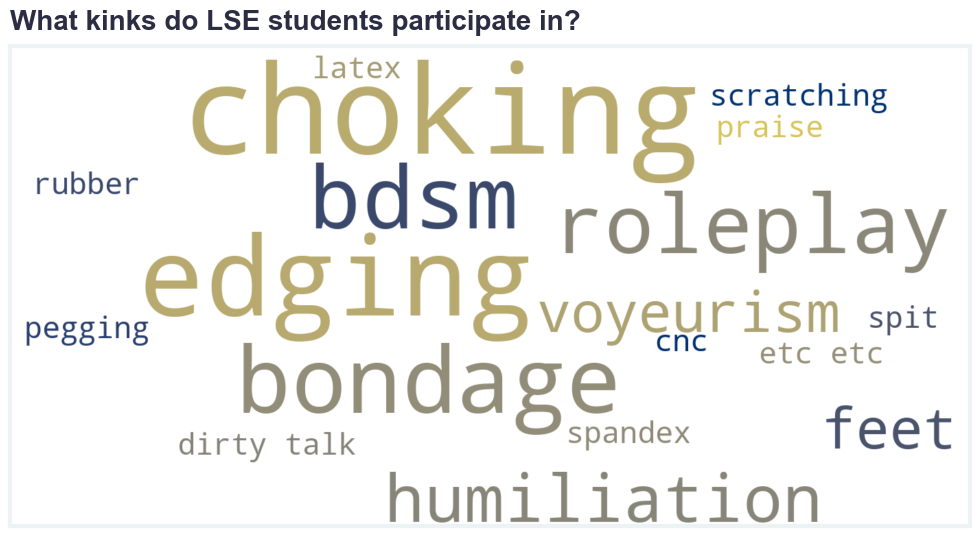

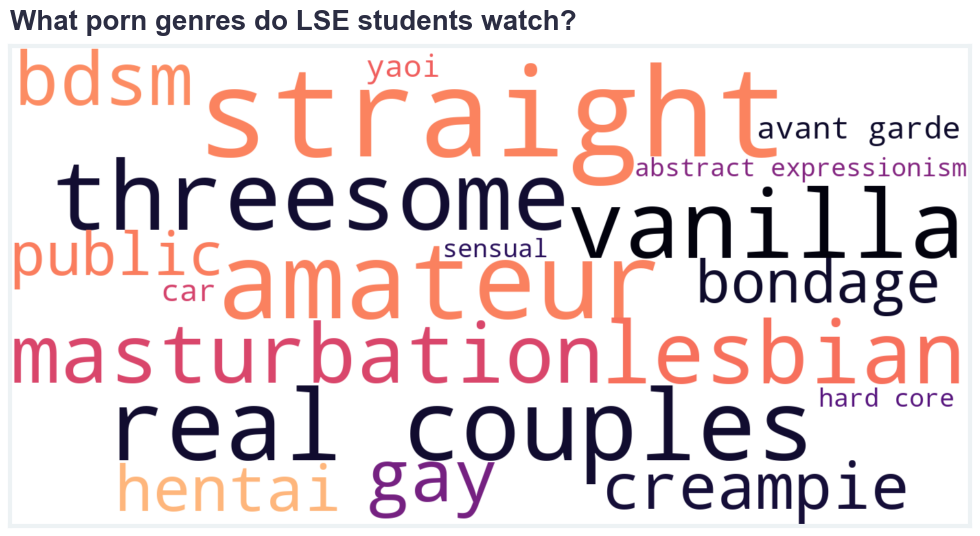

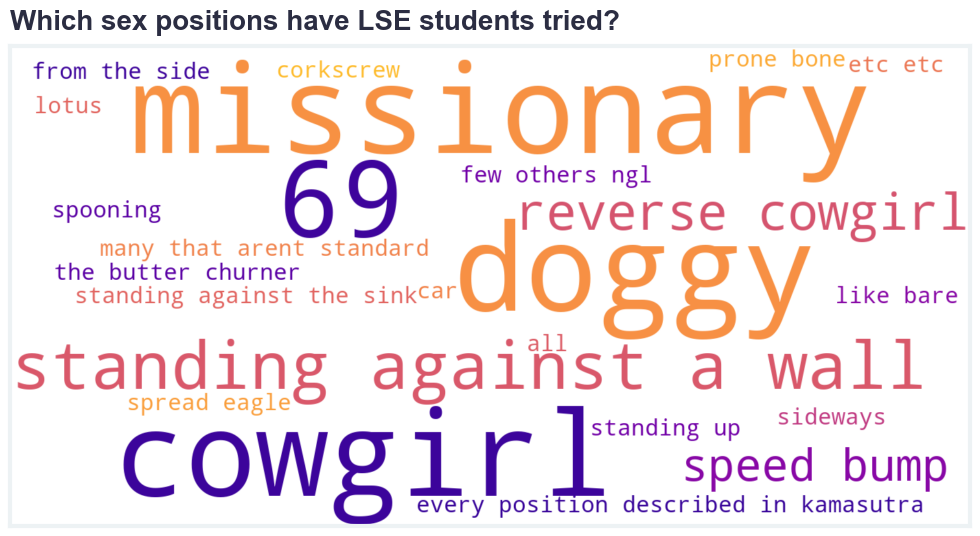

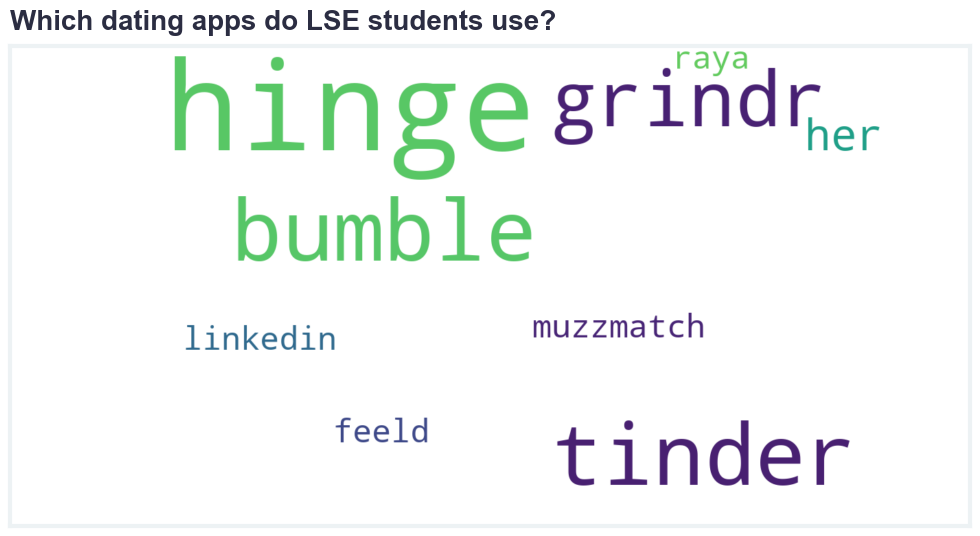

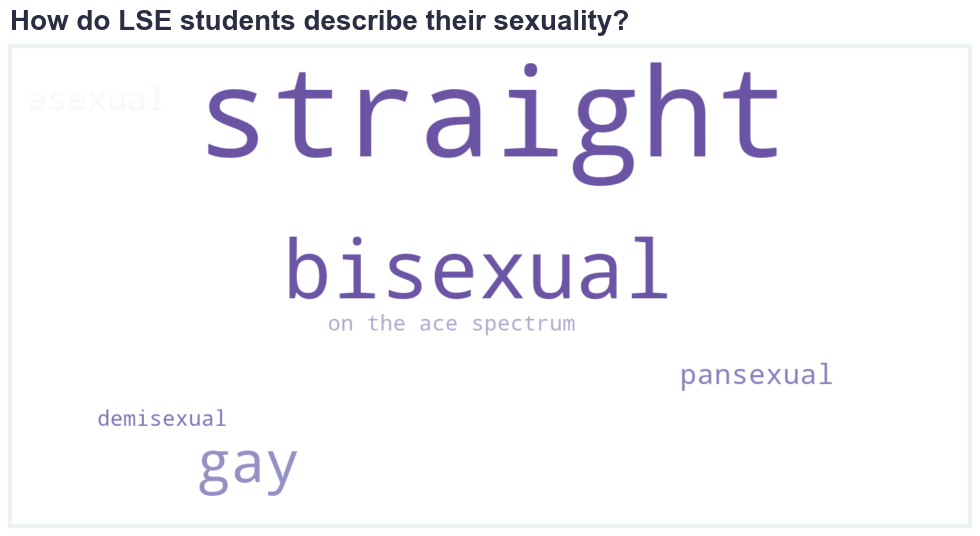

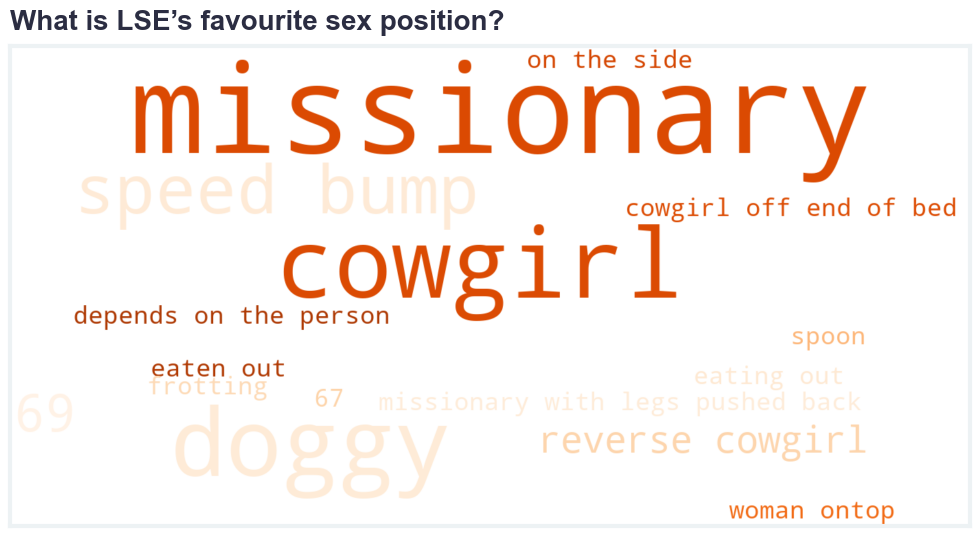

In [49]:
create_visualizations(survey, min_group_size=5)

In [50]:
print(list(survey.columns))

['StartDate', 'EndDate', 'Status', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel', 'UserLanguage', 'Q_DuplicateRespondent', 'Q_BallotBoxStuffing', 'year_of_study', 'lse_accommodation', 'department', 'society_or_sports_team', 'is_virgin', 'body_count', 'sexuality', 'sexuality_other_text', 'gender', 'gender_other_text', 'sex_positions_tried', 'sex_positions_tried_other_text', 'favourite_sex_position', 'favourite_sex_position_other_text', 'had_sex_on_campus', 'sex_on_campus_location', 'kinks_participated', 'kinks_other_text', 'sex_frequency', 'had_same_gender_sex', 'relationship_status', 'number_of_regular_sexual_partners', 'masturbation_frequency', 'watches_porn', 'porn_genres_watched', 'porn_genres_other_text', 'has_cheated', 'has_been_cheated_on', 'had_std', 'std_type', 'had_threesome', 'max_partners_at_once', 'hooked_up_with_sway', 'dating_apps_used', 'dating_apps_other_text', 'sex_positions_tried__69', 'sex_positions_tried__cowgir

In [51]:
def advanced_visuals(df, soc_cols=None, min_n=10):
    """
    Advanced editorial-style visualizations for journalism.
    Beautiful, creative, unique charts that tell compelling data stories.
    """
    import plotly.graph_objects as go
    from sklearn.tree import DecisionTreeClassifier, export_text
    from sklearn.preprocessing import LabelEncoder
    
    viz_dir = os.path.join(os.getcwd(), 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)
    
    def _safe_slug(s):
        s = str(s).strip().lower()
        s = re.sub(r'[^a-z0-9]+', '_', s)
        return re.sub(r'_+', '_', s).strip('_')
    
    def _save_plotly(fig, stem):
        stem = _safe_slug(stem)
        html_path = os.path.join(viz_dir, f'advanced_{stem}.html')
        try:
            fig.write_html(html_path, include_plotlyjs='cdn')
        except Exception as e:
            print(f"⚠️ Could not save {stem}: {e}")
    
    d = df.copy()
    
    # Standardize groups
    if 'lse_accommodation' in d.columns:
        d['lse_accommodation'] = d['lse_accommodation'].replace(ACCOM_SHORT)
    if 'department' in d.columns:
        d['department'] = d['department'].replace(DEPT_SHORT)
    if 'gender' in d.columns:
        d['gender'] = d['gender'].replace({'Male': 'Men', 'Female': 'Women'})
    
    # ==========================================
    # 1. SANKEY: Virginity → Gender → Body Count
    # ==========================================
    
    sankey_data = d[d['is_virgin'].notna() & d['body_count'].notna() & d['gender'].notna()].copy()
    sankey_data = sankey_data[sankey_data['gender'].isin(['Men', 'Women'])]
    
    if len(sankey_data) > min_n:
        BC_ORDER = ['0', '1', '2', '3-5', '5-10', '10-20', '20-50', '50-100', '100+']
        
        flows = []
        for _, row in sankey_data.iterrows():
            virgin_status = "Virgin" if row['is_virgin'] == 'Yes' else "Non-Virgin"
            gender = row['gender']
            bc = row['body_count']
            flows.append({'virgin': virgin_status, 'gender': gender, 'body_count': bc})
        
        flow_df = pd.DataFrame(flows)
        
        # Create nodes in order
        nodes = []
        node_map = {}
        idx = 0
        
        # Virgin/Non-Virgin
        for v in ['Virgin', 'Non-Virgin']:
            node_map[f"virgin_{v}"] = idx
            nodes.append(v)
            idx += 1
        
        # Gender
        for g in ['Men', 'Women']:
            node_map[f"gender_{g}"] = idx
            nodes.append(g)
            idx += 1
        
        # Body Count (ordered)
        for bc in BC_ORDER:
            node_map[f"body_count_{bc}"] = idx
            nodes.append(bc)
            idx += 1
        
        # Create links
        sources = []
        targets = []
        values = []
        
        # Virgin -> Gender
        for (v, g), count in flow_df.groupby(['virgin', 'gender']).size().items():
            if pd.notna(v) and pd.notna(g):
                sources.append(node_map[f"virgin_{v}"])
                targets.append(node_map[f"gender_{g}"])
                values.append(count)
        
        # Gender -> Body Count (ordered by BC_ORDER)
        for (g, bc), count in flow_df.groupby(['gender', 'body_count']).size().items():
            if pd.notna(g) and pd.notna(bc) and bc in BC_ORDER:
                sources.append(node_map[f"gender_{g}"])
                targets.append(node_map[f"body_count_{bc}"])
                values.append(count)
        
        # Use your color palette
        node_colors = (
            [PALETTE['qualitative'][0], PALETTE['qualitative'][1]]  # Virgin/Non-Virgin
            + [PALETTE['qualitative'][2], PALETTE['qualitative'][3]]  # Men/Women
            + [PALETTE['qualitative'][i % len(PALETTE['qualitative'])] for i in range(len(BC_ORDER))]  # Body counts
        )
        
                
        n_virgin = 2
        n_gender = 2
        n_bc = len(BC_ORDER)

        # x positions for the 3 columns
        x_virgin = [0.01] * n_virgin
        x_gender = [0.50] * n_gender
        x_bc     = [0.99] * n_bc

        # y positions (top -> bottom) — evenly spaced
        def spaced_y(n):
            if n == 1:
                return [0.5]
            return [i/(n-1) for i in range(n)]

        y_virgin = spaced_y(n_virgin)
        y_gender = spaced_y(n_gender)
        y_bc     = spaced_y(n_bc)

        node_x = x_virgin + x_gender + x_bc
        node_y = y_virgin + y_gender + y_bc


        fig = go.Figure(data=[go.Sankey(
        arrangement='fixed',   
        node=dict(
            pad=20,
            thickness=25,
            line=dict(color='white', width=2),
            label=nodes,
            color=node_colors,
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color='rgba(0,0,0,0.15)'
        )
    )])
        
        fig.update_layout(
            title=dict(
                text="<b>Body Count Breakdown by Gender and Sexuality</b>",
                font=dict(size=24, color='#2B2D42'),
                x=0.5,
                xanchor='center'
            ),
            font=dict(size=13, family='Helvetica'),
            height=700,
            template='plotly_white',
            margin=dict(l=20, r=20, t=80, b=20)
        )
        
        _save_plotly(fig, 'sankey_virginity_to_experience')
        fig.show()
    
    # ==========================================
    # 2. INFIDELITY GAP: Multiple Breakdowns
    # ==========================================
    print("\n⚖️ Creating infidelity gap charts...")
    
    def _infidelity_diverging(data, group_col, title, min_n_local=10):
        """Create diverging bar chart for cheating balance"""
        subset = data[data[group_col].notna()].copy()
        
        # Remove NaN strings
        subset = subset[~subset[group_col].astype(str).str.lower().isin(['nan', 'none'])].copy()
        
        group_counts = subset[group_col].value_counts()
        valid_groups = group_counts[group_counts >= min_n_local].index
        
        subset = subset[subset[group_col].isin(valid_groups)]
        
        if subset.empty:
            return None
        
        cheat_summary = []
        for grp in valid_groups:
            grp_data = subset[subset[group_col] == grp]
            cheated = (grp_data['has_cheated'] == 'Yes').mean() * 100
            been_cheated = (grp_data['has_been_cheated_on'] == 'Yes').mean() * 100
            cheat_summary.append({
                'group': grp,
                'cheated': cheated,
                'been_cheated_on': -been_cheated
            })
        
        cheat_df = pd.DataFrame(cheat_summary).sort_values('cheated', ascending=True)
        
        if cheat_df.empty:
            return None
        
        fig = go.Figure()
        
        fig.add_trace(go.Bar(
            y=cheat_df['group'],
            x=cheat_df['cheated'],
            name='Have Cheated',
            orientation='h',
            marker=dict(color=PALETTE['qualitative'][4]),
            text=cheat_df['cheated'].round(1).astype(str) + '%',
            textposition='outside',
            hovertemplate='<b>%{y}</b><br>Have Cheated: %{x:.1f}%<extra></extra>'
        ))
        
        fig.add_trace(go.Bar(
            y=cheat_df['group'],
            x=cheat_df['been_cheated_on'],
            name='Been Cheated On',
            orientation='h',
            marker=dict(color=PALETTE['qualitative'][5]),
            text=(-cheat_df['been_cheated_on']).round(1).astype(str) + '%',
            textposition='outside',
            hovertemplate='<b>%{y}</b><br>Been Cheated On: %{x:.1f}%<extra></extra>'
        ))
        
        max_val = max(cheat_df['cheated'].max(), -cheat_df['been_cheated_on'].min())
        range_val = int(np.ceil(max_val / 10) * 10) + 10
        
        fig.update_layout(
            title=dict(
                text=f"<b>{title}</b><br><sub>The infidelity gap: who cheats vs who gets cheated on</sub>",
                font=dict(size=22, color='#2B2D42'),
                x=0.5,
                xanchor='center'
            ),
            barmode='overlay',
            xaxis=dict(
                title='',
                range=[-range_val, range_val],
                tickvals=[-40, -20, 0, 20, 40],
                ticktext=['40%', '20%', '0%', '20%', '40%']
            ),
            yaxis=dict(title=''),
            template='plotly_white',
            height=500,
            showlegend=True,
            legend=dict(
                x=0.5,
                y=-0.15,
                xanchor='center',
                orientation='h',
                font=dict(size=13)
            ),
            margin=dict(l=100, r=50, t=90, b=80)
        )
        
        # Add labels to distinguish sides
        fig.add_annotation(
            x=-range_val * 0.7,
            y=len(cheat_df),
            text="← Been Cheated On",
            showarrow=False,
            font=dict(size=12, color=PALETTE['qualitative'][5]),
            yshift=20
        )
        
        fig.add_annotation(
            x=range_val * 0.7,
            y=len(cheat_df),
            text="Have Cheated →",
            showarrow=False,
            font=dict(size=12, color=PALETTE['qualitative'][4]),
            yshift=20
        )
        
        return fig
    
    # By Department
    fig = _infidelity_diverging(d, 'department', 'Infidelity by Department')
    if fig:
        _save_plotly(fig, 'infidelity_gap_department')
        fig.show()
    
    # By Gender
    fig = _infidelity_diverging(d, 'gender', 'Infidelity by Gender')
    if fig:
        _save_plotly(fig, 'infidelity_gap_gender')
        fig.show()
    
    # By Sexuality
    fig = _infidelity_diverging(d, 'sexuality', 'Infidelity by Sexuality')
    if fig:
        _save_plotly(fig, 'infidelity_gap_sexuality')
        fig.show()
    
    # By Accommodation
    fig = _infidelity_diverging(d, 'lse_accommodation', 'Infidelity by Accommodation')
    if fig:
        _save_plotly(fig, 'infidelity_gap_accommodation')
        fig.show()
    
    # By Gender × Sexuality
    if 'gender' in d.columns and 'sexuality' in d.columns:
        d_temp = d[d['gender'].isin(['Men', 'Women']) & d['sexuality'].isin(['Straight', 'Bisexual', 'Gay'])].copy()
        d_temp['gender_x_sexuality'] = d_temp['sexuality'] + ' ' + d_temp['gender']
        
        fig = _infidelity_diverging(d_temp, 'gender_x_sexuality', 'Infidelity by Gender × Sexuality', min_n_local=15)
        if fig:
            _save_plotly(fig, 'infidelity_gap_gender_sexuality')
            fig.show()
    
    # ==========================================
    # 3. HEATMAP: Body Count × Sex Frequency
    # ==========================================
    print("\n🔥 Creating body count × frequency heatmap...")
    
    if 'body_count' in d.columns and 'sex_frequency' in d.columns:
        heatmap_data = d[d['body_count'].notna() & d['sex_frequency'].notna()].copy()
        
        BC_ORDER = ['0', '1', '2', '3-5', '5-10', '10-20', '20-50', '50-100', '100+']
        FREQ_ORDER = ['Less', 'Once a month', 'Once or twice a week', 
                      'More than five days a week', 'Once a day', 'Multiple times a day']
        
        matrix = pd.crosstab(
            heatmap_data['sex_frequency'],
            heatmap_data['body_count'],
            normalize='all'
        ) * 100
        
        matrix = matrix.reindex(index=FREQ_ORDER, columns=BC_ORDER, fill_value=0)
        
        # Use your color palette - create custom colorscale
        custom_colorscale = [
            [0.0, '#EDF2F4'],      # Light (your neutral_light)
            [0.5, PALETTE['qualitative'][3]],  # Mid
            [1.0, PALETTE['qualitative'][4]]   # Dark
        ]
        
        fig = go.Figure(data=go.Heatmap(
            z=matrix.values,
            x=matrix.columns,
            y=matrix.index,
            colorscale=custom_colorscale,
            text=matrix.values.round(1),
            texttemplate='<b>%{text}%</b>',
            textfont={"size": 12, "color": "white"},
            colorbar=dict(
                title=dict(text="% of Students", side='right'),
                thickness=20,
                len=0.7
            ),
            hovertemplate='<b>Body Count: %{x}</b><br>Frequency: %{y}<br>Percent: %{z:.1f}%<extra></extra>'
        ))
        
        fig.update_layout(
            title=dict(
                text="<b>Experience vs Activity</b><br><sub>Body count compared to current sexual frequency</sub>",
                font=dict(size=24, color='#2B2D42'),
                x=0.5,
                xanchor='center'
            ),
            xaxis=dict(title='<b>Body Count</b>', tickangle=-45, tickfont=dict(size=12), side='bottom'),
            yaxis=dict(title='<b>Sex Frequency</b>', tickfont=dict(size=12)),
            template='plotly_white',
            height=550,
            width=950,
            margin=dict(l=150, r=100, t=100, b=100)
        )
        
        _save_plotly(fig, 'heatmap_bodycount_frequency')
        fig.show()


In [52]:
advanced_visuals(survey, soc_cols=soc_cols, min_n=10)


⚖️ Creating infidelity gap charts...



🔥 Creating body count × frequency heatmap...


In [53]:
# ============================================================================
# 5. DECISION TREE "STORY" VISUALS (TOP→BOTTOM, prettier, more leaves, no leakage)
# Saves to: tree_visualizations/
# ============================================================================

import os
import re
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeClassifier

def build_decision_tree_panels(
    df,
    out_dir='tree_visualizations',
    max_depth=4,              # more leaves than before
    min_samples_leaf=18,      # smaller => more leaves (but still not tiny)
    min_samples_split=36,
    random_state=42
):
    os.makedirs(out_dir, exist_ok=True)

    # ---------------------------
    # Targets
    # ---------------------------
    def _target_virgin(d):
        s = d['is_virgin'].astype(str)
        y = np.where(s.eq('Yes'), 1, np.where(s.eq('No'), 0, np.nan))
        return pd.Series(y, index=d.index, name='target_virgin')

    def _target_bc_over_50(d):
        s = d['body_count'].astype(str)
        y = np.where(s.isin(['50-100', '100+']), 1,
                     np.where(s.isin(['0', '1', '2', '3-5', '5-10', '10-20', '20-50']), 0, np.nan))
        return pd.Series(y, index=d.index, name='target_bc_over_50')

    def _target_in_relationship(d):
        s = d['relationship_status'].astype(str)
        y = np.where(s.eq('Yes'), 1,
                     np.where(s.isin(['No', "It’s complicated", "It's complicated"]), 0, np.nan))
        return pd.Series(y, index=d.index, name='target_in_relationship')

    def _target_cheated_on(d):
        s = d['has_been_cheated_on'].astype(str)
        y = np.where(s.eq('Yes'), 1, np.where(s.eq('No'), 0, np.nan))
        return pd.Series(y, index=d.index, name='target_cheated_on')

    # ---------------------------
    # Feature utilities
    # ---------------------------
    def _is_multihot(col):
        return any(col.startswith(p) for p in [
            'sex_positions_tried__',
            'kinks_participated__',
            'porn_genres_watched__',
            'dating_apps_used__',
            'soc__',
            'std__'
        ])

    def _safe_bool_from_yesno(series):
        s = series.astype(str)
        out = np.where(s.eq('Yes'), 1, np.where(s.eq('No'), 0, np.nan))
        return pd.Series(out, index=series.index)

    def _build_feature_frame(d, base_cols, allow_multihot=True):
        use_cols = [c for c in base_cols if c in d.columns]

        if allow_multihot:
            extra = [c for c in d.columns if _is_multihot(c)]
            use_cols = list(dict.fromkeys(use_cols + extra))

        X_raw = d[use_cols].copy()

        yesno_like = [
            'had_sex_on_campus', 'had_same_gender_sex', 'watches_porn',
            'has_cheated', 'has_been_cheated_on', 'had_threesome',
            'hooked_up_with_sway', 'had_std'
        ]
        for c in yesno_like:
            if c in X_raw.columns:
                X_raw[c] = _safe_bool_from_yesno(X_raw[c])

        for c in X_raw.columns:
            if _is_multihot(c):
                X_raw[c] = pd.to_numeric(X_raw[c], errors='coerce').fillna(0).astype(int)

        # one-hot the remaining categoricals
        cat_cols = []
        for c in X_raw.columns:
            if _is_multihot(c):
                continue
            if not pd.api.types.is_numeric_dtype(X_raw[c]):
                cat_cols.append(c)

        X = pd.get_dummies(X_raw, columns=cat_cols, dummy_na=False)

        # remove constant columns
        nunique = X.nunique(dropna=False)
        X = X[nunique[nunique > 1].index].copy()

        return X.fillna(0)

    # ---------------------------
    # Pretty text
    # ---------------------------
    def _pretty_feature_name(f):
        f = str(f)

        # one-hot categoricals: gender_Men → "Gender is Men?"
        if re.search(r'.+_.+', f) and not _is_multihot(f) and '__' not in f:
            left, right = f.split('_', 1)
            left = left.replace('lse_accommodation', 'Accommodation') \
                       .replace('department', 'Department') \
                       .replace('gender', 'Gender') \
                       .replace('sexuality', 'Sexuality') \
                       .replace('year_of_study', 'Year')
            right = right.replace('_', ' ')
            return f"{left} is {right}?"

        if f.startswith('porn_genres_watched__'):
            item = f.replace('porn_genres_watched__', '').replace('_', ' ')
            return f"Watches {item} porn?"
        if f.startswith('dating_apps_used__'):
            item = f.replace('dating_apps_used__', '').replace('_', ' ')
            return f"Uses {item}?"
        if f.startswith('kinks_participated__'):
            item = f.replace('kinks_participated__', '').replace('_', ' ')
            return f"Into {item}?"
        if f.startswith('sex_positions_tried__'):
            item = f.replace('sex_positions_tried__', '').replace('_', ' ')
            return f"Tried {item}?"
        if f.startswith('soc__'):
            item = f.replace('soc__', '').replace('_', ' ')
            return f"In {item}?"
        if f.startswith('std__'):
            item = f.replace('std__', '').replace('_', ' ')
            return f"STD: {item}?"

        plain_map = {
            'had_sex_on_campus': 'Had sex on campus?',
            'had_same_gender_sex': 'Had same-gender sex?',
            'watches_porn': 'Watches porn?',
            'has_cheated': 'Has cheated?',
            'had_threesome': 'Had a threesome?',
            'hooked_up_with_sway': 'Hooked up with someone from Sway?',
            'had_std': 'Had an STD?'
        }
        if f in plain_map:
            return plain_map[f]

        f2 = f.replace('_', ' ').replace('__', ': ')
        return f2[:1].upper() + f2[1:] + ('?' if not f2.endswith('?') else '')

    def _leaf_bucket(p):
        if p >= 0.85:
            return "almost"
        if p >= 0.65:
            return "prob"
        if p >= 0.35:
            return "maybe"
        if p >= 0.15:
            return "unlikely"
        return "almost_not"

    def _leaf_text(p, leaf_style):
        """
        leaf_style is a dict like:
          {
            "almost": "Almost definitely virgin",
            "prob": "Probably virgin",
            "maybe": "Could go either way",
            "unlikely": "Probably not virgin",
            "almost_not": "Almost definitely not virgin"
          }
        """
        return leaf_style[_leaf_bucket(p)]

    # ---------------------------
    # Color utilities (pretty + informative)
    # ---------------------------
    def _prob_color(p):
        """
        Soft diverging-like: low p = warm/red tint, high p = cool/blue tint
        (kept gentle so it still looks like journalism graphics)
        """
        p = float(np.clip(p, 0, 1))
        # interpolate between two hex colors
        low = np.array([231, 29, 54])   # #E71D36
        high = np.array([46, 134, 171]) # #2E86AB
        mid = np.array([237, 242, 244]) # #EDF2F4  (toward neutral)
        # soften toward mid a bit
        base = low * (1 - p) + high * p
        softened = 0.72 * base + 0.28 * mid
        return f"rgb({int(softened[0])},{int(softened[1])},{int(softened[2])})"

    # ---------------------------
    # Tree → top-to-bottom flow figure
    # ---------------------------
    def _tree_to_flow_figure(clf, feature_names, title, subtitle, leaf_style):
        tree = clf.tree_
        n = tree.node_count
        left = tree.children_left
        right = tree.children_right
        feat = tree.feature
        thr = tree.threshold
        val = tree.value  # [node, 1, n_classes]

        # depth + leaf flags
        depth = np.zeros(n, dtype=int)
        is_leaf = np.zeros(n, dtype=bool)

        stack = [(0, 0)]
        while stack:
            node, d = stack.pop()
            depth[node] = d
            if left[node] == right[node]:
                is_leaf[node] = True
            else:
                stack.append((left[node], d + 1))
                stack.append((right[node], d + 1))

        max_d = int(depth.max()) if n else 1

        # assign x positions by leaf order, then propagate up
        x = np.zeros(n, dtype=float)
        leaf_ids = [i for i in range(n) if is_leaf[i]]
        leaf_ids_sorted = sorted(leaf_ids)

        for i, nid in enumerate(leaf_ids_sorted):
            x[nid] = i

        for nid in sorted(range(n), key=lambda i: -depth[i]):
            if not is_leaf[nid]:
                x[nid] = (x[left[nid]] + x[right[nid]]) / 2.0

        if len(leaf_ids) > 1:
            x = (x - x.min()) / (x.max() - x.min())
        else:
            x = np.ones_like(x) * 0.5

        # y is depth (TOP to BOTTOM): root at y=1, leaves toward 0
        y = 1.0 - (depth / max(1, max_d))

        # edges
        edge_x = []
        edge_y = []
        branch_labels = []
        for nid in range(n):
            if is_leaf[nid]:
                continue
            for child, lab in [(left[nid], "No"), (right[nid], "Yes")]:
                edge_x += [x[nid], x[child], None]
                edge_y += [y[nid], y[child], None]
                branch_labels.append((nid, child, lab))

        # node display + node colors
        node_main = []
        node_sub = []
        node_color = []

        for nid in range(n):
            if is_leaf[nid]:
                counts = val[nid][0]
                p1 = counts[1] / counts.sum() if counts.sum() else 0.0
                node_main.append(f"{_leaf_text(p1, leaf_style)}")
                node_sub.append(f"{p1*100:.0f}% chance")
                node_color.append(_prob_color(p1))
            else:
                f_idx = feat[nid]
                f_name = feature_names[f_idx]
                q = _pretty_feature_name(f_name)
                t = thr[nid]

                if abs(t - 0.5) < 1e-6:
                    node_main.append(q)
                    node_sub.append("")
                else:
                    node_main.append(q.replace('?', ''))
                    node_sub.append(f"≤ {t:.2f}?")

                node_color.append("rgba(43,45,66,0.08)")  # soft neutral

        fig = go.Figure()

        # edges (slightly thicker, attractive)
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            mode='lines',
            line=dict(width=3, color='rgba(43,45,66,0.25)'),
            hoverinfo='skip',
            showlegend=False
        ))

        # nodes
        sizes = [28 if is_leaf[i] else 24 for i in range(n)]
        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode='markers',
            marker=dict(size=sizes, color=node_color, line=dict(width=2, color='white')),
            hoverinfo='skip',
            showlegend=False
        ))

        # node labels (rounded-card look via annotation boxes)
        for nid in range(n):
            main = node_main[nid]
            sub = node_sub[nid]
            txt = f"<b>{main}</b>" + (f"<br><span style='font-size:12px; opacity:0.8'>{sub}</span>" if sub else "")

            # slightly tint leaf boxes to match node color
            bg = "white" if not is_leaf[nid] else "rgba(255,255,255,0.95)"

            fig.add_annotation(
                x=float(x[nid]), y=float(y[nid]),
                text=txt,
                showarrow=False,
                align='center',
                xanchor='center',
                yanchor='middle',
                bgcolor=bg,
                bordercolor='rgba(43,45,66,0.18)',
                borderwidth=2,
                borderpad=9,
                font=dict(size=13, family='Helvetica Neue, Arial')
            )

        # branch labels
        for src, dst, lab in branch_labels:
            mx = (x[src] + x[dst]) / 2.0
            my = (y[src] + y[dst]) / 2.0
            fig.add_annotation(
                x=float(mx), y=float(my),
                text=f"<b>{lab}</b>",
                showarrow=False,
                font=dict(size=12, family='Helvetica Neue, Arial'),
                bgcolor='rgba(255,255,255,0.85)',
                bordercolor='rgba(43,45,66,0.12)',
                borderwidth=1,
                borderpad=3
            )

        fig.update_layout(
            template='plotly_white',
            height=760,
            margin=dict(l=40, r=40, t=105, b=30),
            title=dict(
                text=f"<b>{title}</b><br><span style='font-size:13px; opacity:0.8'>{subtitle}</span>",
                x=0.5, xanchor='center'
            ),
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            paper_bgcolor='white'
        )

        return fig

    # ---------------------------
    # Train + render a panel
    # ---------------------------
    def _train_and_render(d0, y, title, subtitle, base_cols, exclude_cols, leaf_style, allow_multihot=True):
        d = d0.copy()
        d['_y_'] = y
        d = d.dropna(subset=['_y_']).copy()
        d['_y_'] = d['_y_'].astype(int)

        exclude_cols = set(exclude_cols or [])
        exclude_cols.add('_y_')

        base_cols = [c for c in base_cols if c in d.columns and c not in exclude_cols]
        X = _build_feature_frame(d, base_cols, allow_multihot=allow_multihot)

        # aggressively drop excluded “families” after dummying
        if exclude_cols:
            drop_like = []
            for c in X.columns:
                for ex in exclude_cols:
                    if c == ex or c.startswith(ex + '_') or c.startswith(ex + '__') or c.startswith(ex):
                        drop_like.append(c)
            if drop_like:
                X = X.drop(columns=sorted(set(drop_like)), errors='ignore')

        nunique = X.nunique(dropna=False)
        X = X[nunique[nunique > 1].index].copy()

        if X.shape[1] < 2 or len(X) < (min_samples_leaf * 2):
            print(f"⚠️ Not enough usable data/features for: {title}")
            return

        clf = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            min_samples_split=min_samples_split,
            random_state=random_state,
            class_weight='balanced'
        )
        clf.fit(X, d['_y_'])

        fig = _tree_to_flow_figure(
            clf,
            feature_names=list(X.columns),
            title=title,
            subtitle=subtitle,
            leaf_style=leaf_style
        )

        stem = re.sub(r'[^a-z0-9]+', '_', title.strip().lower()).strip('_')
        path = os.path.join(out_dir, f"tree_{stem}.html")
        fig.write_html(path, include_plotlyjs='cdn')
        fig.show()
        print(f"✓ Saved: {path}")

    # ---------------------------
    # Base predictors (general)
    # ---------------------------
    base_cols_general = [
        'lse_accommodation', 'department', 'gender', 'sexuality', 'year_of_study',
        'watches_porn', 'dating_apps_used', 'kinks_participated',
        'had_same_gender_sex', 'had_sex_on_campus', 'hooked_up_with_sway',
        'had_std', 'std_type',
        'has_cheated', 'had_threesome',
        'sex_frequency', 'masturbation_frequency',
        'number_of_regular_sexual_partners', 'body_count',
        'relationship_status', 'has_been_cheated_on'  # NOTE: will be excluded when needed
    ]

    # ---------------------------
    # Leakage rules (your request)
    # ---------------------------
    virgin_exclude = {
        # obvious / circular
        'body_count',
        'number_of_regular_sexual_partners',
        'relationship_status',
        'sex_frequency',
        'masturbation_frequency',
        'favourite_sex_position',
        'sex_positions_tried',
        'sex_positions_tried_other_text',
        # multi-hot family for positions
        'sex_positions_tried__'
    }

    relationship_exclude = {
        # target is derived from relationship_status — exclude it
        'relationship_status'
    }

    cheated_on_exclude = {
        # target is has_been_cheated_on — exclude it
        'has_been_cheated_on',
        # you also explicitly said exclude relationship_status here
        'relationship_status'
    }

    # ---------------------------
    # Leaf label styles (short + readable)
    # ---------------------------
    leaf_style_virgin = {
        "almost": "Almost definitely virgin",
        "prob": "Probably virgin",
        "maybe": "Could go either way",
        "unlikely": "Probably not virgin",
        "almost_not": "Almost definitely not virgin"
    }

    leaf_style_50plus = {
        "almost": "Almost definitely 50+",
        "prob": "Probably 50+",
        "maybe": "Could go either way",
        "unlikely": "Probably not 50+",
        "almost_not": "Almost definitely not 50+"
    }

    leaf_style_relationship = {
        "almost": "Almost definitely taken",
        "prob": "Probably taken",
        "maybe": "Could go either way",
        "unlikely": "Probably not taken",
        "almost_not": "Almost definitely not taken"
    }

    leaf_style_cheated_on = {
        "almost": "Almost definitely cheated on",
        "prob": "Probably cheated on",
        "maybe": "Could go either way",
        "unlikely": "Probably not cheated on",
        "almost_not": "Almost definitely not cheated on"
    }

    print("\n" + "=" * 90)
    print("TREE VISUALIZATIONS (TOP→BOTTOM, CLEAN, READABLE)")
    print("=" * 90)

    # 1) Virgin
    _train_and_render(
        df,
        _target_virgin(df),
        title="Who is most likely to be a virgin?",
        subtitle="Simple decision path (small tree, readable splits — no obvious circular predictors)",
        base_cols=base_cols_general,
        exclude_cols=virgin_exclude,
        leaf_style=leaf_style_virgin,
        allow_multihot=True
    )

    # 2) Body count 50+
    _train_and_render(
        df,
        _target_bc_over_50(df),
        title="Who is most likely to have a body count over 50?",
        subtitle="Simple decision path (small tree, readable splits)",
        base_cols=base_cols_general,
        exclude_cols=set(),   # here richer predictors are fine
        leaf_style=leaf_style_50plus,
        allow_multihot=True
    )

    # 3) Relationship (exclude relationship_status predictors)
    _train_and_render(
        df,
        _target_in_relationship(df),
        title="Who is most likely to be in a relationship?",
        subtitle="Simple decision path (small tree, readable splits — excludes the relationship-status field itself)",
        base_cols=base_cols_general,
        exclude_cols=relationship_exclude,
        leaf_style=leaf_style_relationship,
        allow_multihot=True
    )

    # 4) Been cheated on (exclude has_been_cheated_on + relationship_status)
    _train_and_render(
        df,
        _target_cheated_on(df),
        title="Who is most likely to have been cheated on?",
        subtitle="Simple decision path (small tree, readable splits — excludes the cheated-on field and relationship status)",
        base_cols=base_cols_general,
        exclude_cols=cheated_on_exclude,
        leaf_style=leaf_style_cheated_on,
        allow_multihot=True
    )

    print(f"\nDone. Saved all tree HTMLs in: {out_dir}/\n")


# Run it
build_decision_tree_panels(survey)



TREE VISUALIZATIONS (TOP→BOTTOM, CLEAN, READABLE)


✓ Saved: tree_visualizations/tree_who_is_most_likely_to_be_a_virgin.html


✓ Saved: tree_visualizations/tree_who_is_most_likely_to_have_a_body_count_over_50.html


✓ Saved: tree_visualizations/tree_who_is_most_likely_to_be_in_a_relationship.html


✓ Saved: tree_visualizations/tree_who_is_most_likely_to_have_been_cheated_on.html

Done. Saved all tree HTMLs in: tree_visualizations/

